# Notebook 14:  Ising Phases using Convolutional Neural Networks in PyTorch 
Yi Ming Chang<br>
B00751897 <br>
Mar 13th, 2021

## Exercises

* Do __Step 6__: modify the hyperparameters to optimize performance for the specific data set
* The strides used above do not account for the periodic boundary conditions. Define your own stride function in PyTorch to incorporate periodic boundary conditions

# Instead of download the dataset. I change the code to read it online itself like we did in NB12, and everything works fine. 

In [3]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
from torchvision import datasets # load data

from sklearn.model_selection import train_test_split
import collections
import pickle as pickle
import pickle, os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from urllib.request import urlopen

class Ising_Dataset(torch.utils.data.Dataset):
    """Ising pytorch dataset."""

    def __init__(self, data_type, transform=False):
        """
        Args:
            data_type (string): `train`, `test` or `critical`: creates data_loader
            transform (callable, optional): Optional transform to be applied on a sample.

        """
        L=40 # linear system size
        T=np.linspace(0.25,4.0,16) # temperatures
        T_c=2.26 # critical temperature in the TD limit

        # path to data directory
        url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

        ######### LOAD DATA
        # The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
        data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
        # The labels are obtained from the following file:
        label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

        #DATA
        data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
        data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
        data=data.astype('int')
        data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

        #LABELS (convention is 1 for ordered states and 0 for disordered states)
        labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

        print("Finished loading data")
        # divide data into ordered, critical and disordered
      
        X_ordered=data[:70000,:]
        Y_ordered=labels[:70000]

        X_critical=data[70000:100000,:]
        Y_critical=labels[70000:100000]

        X_disordered=data[100000:,:]
        Y_disordered=labels[100000:]

        del data,labels
        
        # define training, critical and test data sets
        X=np.concatenate((X_ordered,X_disordered)) #np.concatenate((X_ordered,X_critical,X_disordered))
        Y=np.concatenate((Y_ordered,Y_disordered)) #np.concatenate((Y_ordered,Y_critical,Y_disordered))

        # pick random data points from ordered and disordered states to create the training and test sets
        X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,train_size=0.8)


        if data_type=='train':
            X=X_train
            Y=Y_train
            print("Training on 80 percent of examples")

        if data_type=='test':
            X=X_test
            Y=Y_test
            print("Testing on 20 percent of examples")

        if data_type=='critical':
            X=X_critical
            Y=Y_critical
            print("Predicting on %i critical examples"%len(Y_critical))

        # reshape data back to original 2D-array form
        X=X.reshape(X.shape[0],40,40)

        # these are necessary attributes in dataset class and must be assigned
        self.data=(X,Y)
        self.transform = transform


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):
        sample=(self.data[0][idx,...],self.data[1][idx])
        if self.transform:
            sample=self.transform(sample)
        return sample
    

def load_data(kwargs):
    # kwargs:  CUDA arguments, if enabled
    # load and noralise train,test, and data
    train_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='train'),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='test'),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    critical_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='critical'),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader, critical_loader

In [5]:
import torch.nn as nn # construct NN

class model(nn.Module):
    # create convolutional net
    def __init__(self, N=10, L=40):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()	
        # create convolutional layer with input depth 1 and output depth N
        self.conv1 = nn.Conv2d(1, N, kernel_size=2, padding=1)
        # batch norm layer takes Depth
        self.bn1=nn.BatchNorm2d(N) 
        # create fully connected layer after maxpool operation reduced 40->18
        self.fc1 = nn.Linear(20*20*N, 2) 	
        self.N=N
        self.L=L
        print("The number of neurons in CNN layer is %i"%(N))

    def forward(self, x):
        #Unsqueeze command indicates one channel and turns x.shape from (:,40,40) to (:,1, 40,40)
        x=F.relu(self.conv1(torch.unsqueeze(x,1).float()))
        #print(x.shape)  often useful to look at shapes for debugging
        x = F.max_pool2d(x,2)	 
        #print(x.shape)
        x=self.bn1(x) # largely unnecessary and here just for pedagogical purposes
        return F.log_softmax(self.fc1(x.view(-1,20*20*self.N)), dim=1)

In [6]:

def train(epoch):
    # these are very standard functions for going over data to train

    CNN.train() # effects Dropout and BatchNorm layers
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = CNN(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(data_loader,verbose='Test'):
    # these are very standard functions for evaluating data

    CNN.eval() # effects Dropout and BatchNorm layers
    test_loss = 0
    correct = 0
    for data, target in data_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        output = CNN(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(data_loader.dataset)
    print('\n'+verbose+' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    accuracy=100. * correct / len(data_loader.dataset)
    return(accuracy)

# For modify the hyperparameters to optimize performance, I have first change the optimizer to Adam to see how it effect on the performance

In [ ]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# training settings
parser = argparse.ArgumentParser(description='PyTorch Convmodel Ising Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.epochs=5
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

cuda_kwargs = {'num_workers': 0, 'pin_memory': True} if args.cuda else {}

import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

# load data
train_loader, test_loader, critical_loader=load_data(cuda_kwargs)

test_array=[]
critical_array=[]

# create array of depth of convolutional layer
N_array=[1,5,10,20,50]

# loop over depths
for N in N_array:
    CNN = model(N=N)
    if args.cuda:
        CNN.cuda()

    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    #optimizer = optim.SGD(CNN.parameters(), lr=args.lr, momentum=args.momentum)
    optimizer = optim.Adam(CNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    # train the CNN and test its performance at each epoch
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        if epoch==args.epochs:
            test_array.append(test(test_loader,verbose='Test'))
            critical_array.append(test(critical_loader,verbose='Critical'))
        else:
            test(test_loader,verbose='Test')
            test(critical_loader,verbose='Critical')
    print(test_array)
    print(critical_array)

Finished loading data
Training on 80 percent of examples
Finished loading data
Testing on 20 percent of examples
Finished loading data
Predicting on 30000 critical examples
The number of neurons in CNN layer is 1
Train Epoch: 1 [0/104000 (0%)]	Loss: 0.596627
Train Epoch: 1 [640/104000 (1%)]	Loss: 0.175510
Train Epoch: 1 [1280/104000 (1%)]	Loss: 0.027858
Train Epoch: 1 [1920/104000 (2%)]	Loss: 0.013232
Train Epoch: 1 [2560/104000 (2%)]	Loss: 0.008803
Train Epoch: 1 [3200/104000 (3%)]	Loss: 0.007043
Train Epoch: 1 [3840/104000 (4%)]	Loss: 0.005398
Train Epoch: 1 [4480/104000 (4%)]	Loss: 0.008245
Train Epoch: 1 [5120/104000 (5%)]	Loss: 0.012192
Train Epoch: 1 [5760/104000 (6%)]	Loss: 0.005993
Train Epoch: 1 [6400/104000 (6%)]	Loss: 0.002960
Train Epoch: 1 [7040/104000 (7%)]	Loss: 0.021784
Train Epoch: 1 [7680/104000 (7%)]	Loss: 0.003863
Train Epoch: 1 [8320/104000 (8%)]	Loss: 0.002786
Train Epoch: 1 [8960/104000 (9%)]	Loss: 0.013557
Train Epoch: 1 [9600/104000 (9%)]	Loss: 0.006629
Train E

Train Epoch: 1 [101120/104000 (97%)]	Loss: 0.000007
Train Epoch: 1 [101760/104000 (98%)]	Loss: 0.000000
Train Epoch: 1 [102400/104000 (98%)]	Loss: 0.000001
Train Epoch: 1 [103040/104000 (99%)]	Loss: 0.000001
Train Epoch: 1 [103680/104000 (100%)]	Loss: 0.000007


C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5755, Accuracy: 24858/30000 (83%)

Train Epoch: 2 [0/104000 (0%)]	Loss: 0.000001
Train Epoch: 2 [640/104000 (1%)]	Loss: 0.000004
Train Epoch: 2 [1280/104000 (1%)]	Loss: 0.000002
Train Epoch: 2 [1920/104000 (2%)]	Loss: 0.000045
Train Epoch: 2 [2560/104000 (2%)]	Loss: 0.000002
Train Epoch: 2 [3200/104000 (3%)]	Loss: 0.000001
Train Epoch: 2 [3840/104000 (4%)]	Loss: 0.000001
Train Epoch: 2 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 2 [5120/104000 (5%)]	Loss: 0.000003
Train Epoch: 2 [5760/104000 (6%)]	Loss: 0.000046
Train Epoch: 2 [6400/104000 (6%)]	Loss: 0.000001
Train Epoch: 2 [7040/104000 (7%)]	Loss: 0.000002
Train Epoch: 2 [7680/104000 (7%)]	Loss: 0.000013
Train Epoch: 2 [8320/104000 (8%)]	Loss: 0.000001
Train Epoch: 2 [8960/104000 (9%)]	Loss: 0.000414
Train Epoch: 2 [9600/104000 (9%)]	Loss: 0.000001
Train Epoch: 2 [10240/104000 (10%)]	Loss: 0.000001
Train Epoch: 2 [10880/104000 (10%)]	Loss

Train Epoch: 2 [101760/104000 (98%)]	Loss: 0.000000
Train Epoch: 2 [102400/104000 (98%)]	Loss: 0.000000
Train Epoch: 2 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 2 [103680/104000 (100%)]	Loss: 0.000000


# It surprises me, the accuracy of critical point over 90%, unlike in the notebook it said the range of the accuracy is around 80-90%, which I believe Adam optimizer works better than SGD in this case. Then I wonder how about change the learning rate. So I change the learning rate to 0.001

In [ ]:
from matplotlib import pyplot as plt

## Print the result for different N
%matplotlib inline

plt.plot(N_array, test_array, 'r-*', label="test")
plt.plot(N_array, critical_array, 'b-s', label="critical")
plt.ylim(60,110)
plt.xlabel('Depth of hidden layer', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()


In [7]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# training settings
parser = argparse.ArgumentParser(description='PyTorch Convmodel Ising Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.epochs=5
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

cuda_kwargs = {'num_workers': 0, 'pin_memory': True} if args.cuda else {}

import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

# load data
train_loader, test_loader, critical_loader=load_data(cuda_kwargs)

test_array=[]
critical_array=[]

# create array of depth of convolutional layer
N_array=[1,5,10,20,50]

# loop over depths
for N in N_array:
    CNN = model(N=N)
    if args.cuda:
        CNN.cuda()

    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    #optimizer = optim.SGD(CNN.parameters(), lr=args.lr, momentum=args.momentum)
    optimizer = optim.Adam(CNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    # train the CNN and test its performance at each epoch
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        if epoch==args.epochs:
            test_array.append(test(test_loader,verbose='Test'))
            critical_array.append(test(critical_loader,verbose='Critical'))
        else:
            test(test_loader,verbose='Test')
            test(critical_loader,verbose='Critical')
    print(test_array)
    print(critical_array)

Finished loading data
Training on 80 percent of examples
Finished loading data
Testing on 20 percent of examples
Finished loading data
Predicting on 30000 critical examples
The number of neurons in CNN layer is 1
Train Epoch: 1 [0/104000 (0%)]	Loss: 0.638771
Train Epoch: 1 [640/104000 (1%)]	Loss: 0.132331
Train Epoch: 1 [1280/104000 (1%)]	Loss: 0.040286
Train Epoch: 1 [1920/104000 (2%)]	Loss: 0.011618
Train Epoch: 1 [2560/104000 (2%)]	Loss: 0.010079
Train Epoch: 1 [3200/104000 (3%)]	Loss: 0.007446
Train Epoch: 1 [3840/104000 (4%)]	Loss: 0.008975
Train Epoch: 1 [4480/104000 (4%)]	Loss: 0.004082
Train Epoch: 1 [5120/104000 (5%)]	Loss: 0.007062
Train Epoch: 1 [5760/104000 (6%)]	Loss: 0.009351
Train Epoch: 1 [6400/104000 (6%)]	Loss: 0.004490
Train Epoch: 1 [7040/104000 (7%)]	Loss: 0.007478
Train Epoch: 1 [7680/104000 (7%)]	Loss: 0.003972
Train Epoch: 1 [8320/104000 (8%)]	Loss: 0.001448
Train Epoch: 1 [8960/104000 (9%)]	Loss: 0.001919
Train Epoch: 1 [9600/104000 (9%)]	Loss: 0.008233
Train E

Train Epoch: 1 [102400/104000 (98%)]	Loss: 0.000001
Train Epoch: 1 [103040/104000 (99%)]	Loss: 0.000004
Train Epoch: 1 [103680/104000 (100%)]	Loss: 0.000001


C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5990, Accuracy: 24885/30000 (83%)

Train Epoch: 2 [0/104000 (0%)]	Loss: 0.000004
Train Epoch: 2 [640/104000 (1%)]	Loss: 0.000003
Train Epoch: 2 [1280/104000 (1%)]	Loss: 0.000011
Train Epoch: 2 [1920/104000 (2%)]	Loss: 0.000002
Train Epoch: 2 [2560/104000 (2%)]	Loss: 0.000004
Train Epoch: 2 [3200/104000 (3%)]	Loss: 0.000001
Train Epoch: 2 [3840/104000 (4%)]	Loss: 0.000008
Train Epoch: 2 [4480/104000 (4%)]	Loss: 0.000001
Train Epoch: 2 [5120/104000 (5%)]	Loss: 0.000003
Train Epoch: 2 [5760/104000 (6%)]	Loss: 0.000001
Train Epoch: 2 [6400/104000 (6%)]	Loss: 0.000001
Train Epoch: 2 [7040/104000 (7%)]	Loss: 0.000254
Train Epoch: 2 [7680/104000 (7%)]	Loss: 0.000001
Train Epoch: 2 [8320/104000 (8%)]	Loss: 0.000000
Train Epoch: 2 [8960/104000 (9%)]	Loss: 0.000010
Train Epoch: 2 [9600/104000 (9%)]	Loss: 0.000001
Train Epoch: 2 [10240/104000 (10%)]	Loss: 0.000003
Train Epoch: 2 [10880/104000 (10%)]	Loss

Train Epoch: 2 [101760/104000 (98%)]	Loss: 0.000000
Train Epoch: 2 [102400/104000 (98%)]	Loss: 0.000001
Train Epoch: 2 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 2 [103680/104000 (100%)]	Loss: 0.000001

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5020, Accuracy: 25014/30000 (83%)

Train Epoch: 3 [0/104000 (0%)]	Loss: 0.000000
Train Epoch: 3 [640/104000 (1%)]	Loss: 0.000001
Train Epoch: 3 [1280/104000 (1%)]	Loss: 0.000000
Train Epoch: 3 [1920/104000 (2%)]	Loss: 0.000000
Train Epoch: 3 [2560/104000 (2%)]	Loss: 0.000000
Train Epoch: 3 [3200/104000 (3%)]	Loss: 0.000000
Train Epoch: 3 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 3 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 3 [5120/104000 (5%)]	Loss: 0.000001
Train Epoch: 3 [5760/104000 (6%)]	Loss: 0.000002
Train Epoch: 3 [6400/104000 (6%)]	Loss: 0.000001
Train Epoch: 3 [7040/104000 (7%)]	Loss: 0.000000
Train Epoch: 3 [7680/104000 (7%)]	Loss: 0.000000
Train Epoch: 3 [8320/104000 (

Train Epoch: 3 [99200/104000 (95%)]	Loss: 0.000000
Train Epoch: 3 [99840/104000 (96%)]	Loss: 0.000000
Train Epoch: 3 [100480/104000 (97%)]	Loss: 0.000000
Train Epoch: 3 [101120/104000 (97%)]	Loss: 0.000000
Train Epoch: 3 [101760/104000 (98%)]	Loss: 0.000005
Train Epoch: 3 [102400/104000 (98%)]	Loss: 0.000005
Train Epoch: 3 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 3 [103680/104000 (100%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.3144, Accuracy: 26460/30000 (88%)

Train Epoch: 4 [0/104000 (0%)]	Loss: 0.000000
Train Epoch: 4 [640/104000 (1%)]	Loss: 0.000000
Train Epoch: 4 [1280/104000 (1%)]	Loss: 0.000001
Train Epoch: 4 [1920/104000 (2%)]	Loss: 0.000001
Train Epoch: 4 [2560/104000 (2%)]	Loss: 0.000001
Train Epoch: 4 [3200/104000 (3%)]	Loss: 0.000000
Train Epoch: 4 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 4 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 4 [5120/104000 (5%)]	Loss: 0.000000
Train Epoch: 4 [576

Train Epoch: 4 [97280/104000 (94%)]	Loss: 0.000000
Train Epoch: 4 [97920/104000 (94%)]	Loss: 0.000000
Train Epoch: 4 [98560/104000 (95%)]	Loss: 0.000000
Train Epoch: 4 [99200/104000 (95%)]	Loss: 0.000000
Train Epoch: 4 [99840/104000 (96%)]	Loss: 0.000000
Train Epoch: 4 [100480/104000 (97%)]	Loss: 0.000000
Train Epoch: 4 [101120/104000 (97%)]	Loss: 0.000000
Train Epoch: 4 [101760/104000 (98%)]	Loss: 0.000000
Train Epoch: 4 [102400/104000 (98%)]	Loss: 0.000001
Train Epoch: 4 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 4 [103680/104000 (100%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5719, Accuracy: 24444/30000 (81%)

Train Epoch: 5 [0/104000 (0%)]	Loss: 0.000000
Train Epoch: 5 [640/104000 (1%)]	Loss: 0.000000
Train Epoch: 5 [1280/104000 (1%)]	Loss: 0.000000
Train Epoch: 5 [1920/104000 (2%)]	Loss: 0.000000
Train Epoch: 5 [2560/104000 (2%)]	Loss: 0.000000
Train Epoch: 5 [3200/104000 (3%)]	Loss: 0.000000
Train Epoch: 

Train Epoch: 5 [96000/104000 (92%)]	Loss: 0.000000
Train Epoch: 5 [96640/104000 (93%)]	Loss: 0.000000
Train Epoch: 5 [97280/104000 (94%)]	Loss: 0.000000
Train Epoch: 5 [97920/104000 (94%)]	Loss: 0.000000
Train Epoch: 5 [98560/104000 (95%)]	Loss: 0.000000
Train Epoch: 5 [99200/104000 (95%)]	Loss: 0.000005
Train Epoch: 5 [99840/104000 (96%)]	Loss: 0.000000
Train Epoch: 5 [100480/104000 (97%)]	Loss: 0.000000
Train Epoch: 5 [101120/104000 (97%)]	Loss: 0.000000
Train Epoch: 5 [101760/104000 (98%)]	Loss: 0.000000
Train Epoch: 5 [102400/104000 (98%)]	Loss: 0.000000
Train Epoch: 5 [103040/104000 (99%)]	Loss: 0.000001
Train Epoch: 5 [103680/104000 (100%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5859, Accuracy: 24502/30000 (82%)

[100.0]
[81.67333333333333]
The number of neurons in CNN layer is 5
Train Epoch: 1 [0/104000 (0%)]	Loss: 0.650506
Train Epoch: 1 [640/104000 (1%)]	Loss: 0.001303
Train Epoch: 1 [1280/104000 (1%)]	Loss:

Train Epoch: 1 [93440/104000 (90%)]	Loss: 0.000002
Train Epoch: 1 [94080/104000 (90%)]	Loss: 0.000018
Train Epoch: 1 [94720/104000 (91%)]	Loss: 0.000009
Train Epoch: 1 [95360/104000 (92%)]	Loss: 0.000006
Train Epoch: 1 [96000/104000 (92%)]	Loss: 0.000003
Train Epoch: 1 [96640/104000 (93%)]	Loss: 0.000003
Train Epoch: 1 [97280/104000 (94%)]	Loss: 0.000000
Train Epoch: 1 [97920/104000 (94%)]	Loss: 0.000001
Train Epoch: 1 [98560/104000 (95%)]	Loss: 0.000002
Train Epoch: 1 [99200/104000 (95%)]	Loss: 0.000007
Train Epoch: 1 [99840/104000 (96%)]	Loss: 0.000021
Train Epoch: 1 [100480/104000 (97%)]	Loss: 0.000001
Train Epoch: 1 [101120/104000 (97%)]	Loss: 0.000001
Train Epoch: 1 [101760/104000 (98%)]	Loss: 0.000003
Train Epoch: 1 [102400/104000 (98%)]	Loss: 0.000003
Train Epoch: 1 [103040/104000 (99%)]	Loss: 0.000003
Train Epoch: 1 [103680/104000 (100%)]	Loss: 0.000001

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.3957, Accuracy: 25047/30000 (83%

Train Epoch: 2 [90880/104000 (87%)]	Loss: 0.000010
Train Epoch: 2 [91520/104000 (88%)]	Loss: 0.000002
Train Epoch: 2 [92160/104000 (89%)]	Loss: 0.000000
Train Epoch: 2 [92800/104000 (89%)]	Loss: 0.000001
Train Epoch: 2 [93440/104000 (90%)]	Loss: 0.000000
Train Epoch: 2 [94080/104000 (90%)]	Loss: 0.000001
Train Epoch: 2 [94720/104000 (91%)]	Loss: 0.000000
Train Epoch: 2 [95360/104000 (92%)]	Loss: 0.000002
Train Epoch: 2 [96000/104000 (92%)]	Loss: 0.000000
Train Epoch: 2 [96640/104000 (93%)]	Loss: 0.000005
Train Epoch: 2 [97280/104000 (94%)]	Loss: 0.000001
Train Epoch: 2 [97920/104000 (94%)]	Loss: 0.000006
Train Epoch: 2 [98560/104000 (95%)]	Loss: 0.000002
Train Epoch: 2 [99200/104000 (95%)]	Loss: 0.000002
Train Epoch: 2 [99840/104000 (96%)]	Loss: 0.000001
Train Epoch: 2 [100480/104000 (97%)]	Loss: 0.000000
Train Epoch: 2 [101120/104000 (97%)]	Loss: 0.000009
Train Epoch: 2 [101760/104000 (98%)]	Loss: 0.000001
Train Epoch: 2 [102400/104000 (98%)]	Loss: 0.000000
Train Epoch: 2 [103040/1040

Train Epoch: 3 [88320/104000 (85%)]	Loss: 0.000000
Train Epoch: 3 [88960/104000 (86%)]	Loss: 0.000001
Train Epoch: 3 [89600/104000 (86%)]	Loss: 0.000003
Train Epoch: 3 [90240/104000 (87%)]	Loss: 0.000000
Train Epoch: 3 [90880/104000 (87%)]	Loss: 0.000000
Train Epoch: 3 [91520/104000 (88%)]	Loss: 0.000000
Train Epoch: 3 [92160/104000 (89%)]	Loss: 0.000000
Train Epoch: 3 [92800/104000 (89%)]	Loss: 0.000000
Train Epoch: 3 [93440/104000 (90%)]	Loss: 0.000000
Train Epoch: 3 [94080/104000 (90%)]	Loss: 0.000000
Train Epoch: 3 [94720/104000 (91%)]	Loss: 0.000000
Train Epoch: 3 [95360/104000 (92%)]	Loss: 0.000000
Train Epoch: 3 [96000/104000 (92%)]	Loss: 0.000000
Train Epoch: 3 [96640/104000 (93%)]	Loss: 0.000001
Train Epoch: 3 [97280/104000 (94%)]	Loss: 0.000000
Train Epoch: 3 [97920/104000 (94%)]	Loss: 0.000000
Train Epoch: 3 [98560/104000 (95%)]	Loss: 0.000000
Train Epoch: 3 [99200/104000 (95%)]	Loss: 0.000000
Train Epoch: 3 [99840/104000 (96%)]	Loss: 0.000000
Train Epoch: 3 [100480/104000 (

Train Epoch: 4 [86400/104000 (83%)]	Loss: 0.000000
Train Epoch: 4 [87040/104000 (84%)]	Loss: 0.000000
Train Epoch: 4 [87680/104000 (84%)]	Loss: 0.000000
Train Epoch: 4 [88320/104000 (85%)]	Loss: 0.000000
Train Epoch: 4 [88960/104000 (86%)]	Loss: 0.000000
Train Epoch: 4 [89600/104000 (86%)]	Loss: 0.000001
Train Epoch: 4 [90240/104000 (87%)]	Loss: 0.000000
Train Epoch: 4 [90880/104000 (87%)]	Loss: 0.000000
Train Epoch: 4 [91520/104000 (88%)]	Loss: 0.000001
Train Epoch: 4 [92160/104000 (89%)]	Loss: 0.000000
Train Epoch: 4 [92800/104000 (89%)]	Loss: 0.000000
Train Epoch: 4 [93440/104000 (90%)]	Loss: 0.000000
Train Epoch: 4 [94080/104000 (90%)]	Loss: 0.000000
Train Epoch: 4 [94720/104000 (91%)]	Loss: 0.000041
Train Epoch: 4 [95360/104000 (92%)]	Loss: 0.000000
Train Epoch: 4 [96000/104000 (92%)]	Loss: 0.000000
Train Epoch: 4 [96640/104000 (93%)]	Loss: 0.000000
Train Epoch: 4 [97280/104000 (94%)]	Loss: 0.000000
Train Epoch: 4 [97920/104000 (94%)]	Loss: 0.000001
Train Epoch: 4 [98560/104000 (9

Train Epoch: 5 [83840/104000 (81%)]	Loss: 0.000003
Train Epoch: 5 [84480/104000 (81%)]	Loss: 0.000000
Train Epoch: 5 [85120/104000 (82%)]	Loss: 0.000000
Train Epoch: 5 [85760/104000 (82%)]	Loss: 0.000000
Train Epoch: 5 [86400/104000 (83%)]	Loss: 0.000000
Train Epoch: 5 [87040/104000 (84%)]	Loss: 0.000000
Train Epoch: 5 [87680/104000 (84%)]	Loss: 0.000000
Train Epoch: 5 [88320/104000 (85%)]	Loss: 0.000000
Train Epoch: 5 [88960/104000 (86%)]	Loss: 0.000000
Train Epoch: 5 [89600/104000 (86%)]	Loss: 0.000000
Train Epoch: 5 [90240/104000 (87%)]	Loss: 0.000001
Train Epoch: 5 [90880/104000 (87%)]	Loss: 0.000000
Train Epoch: 5 [91520/104000 (88%)]	Loss: 0.000000
Train Epoch: 5 [92160/104000 (89%)]	Loss: 0.000000
Train Epoch: 5 [92800/104000 (89%)]	Loss: 0.000000
Train Epoch: 5 [93440/104000 (90%)]	Loss: 0.000000
Train Epoch: 5 [94080/104000 (90%)]	Loss: 0.000000
Train Epoch: 5 [94720/104000 (91%)]	Loss: 0.000002
Train Epoch: 5 [95360/104000 (92%)]	Loss: 0.000000
Train Epoch: 5 [96000/104000 (9

Train Epoch: 1 [80000/104000 (77%)]	Loss: 0.000000
Train Epoch: 1 [80640/104000 (78%)]	Loss: 0.000000
Train Epoch: 1 [81280/104000 (78%)]	Loss: 0.000000
Train Epoch: 1 [81920/104000 (79%)]	Loss: 0.000000
Train Epoch: 1 [82560/104000 (79%)]	Loss: 0.000000
Train Epoch: 1 [83200/104000 (80%)]	Loss: 0.000000
Train Epoch: 1 [83840/104000 (81%)]	Loss: 0.000000
Train Epoch: 1 [84480/104000 (81%)]	Loss: 0.000004
Train Epoch: 1 [85120/104000 (82%)]	Loss: 0.000000
Train Epoch: 1 [85760/104000 (82%)]	Loss: 0.000000
Train Epoch: 1 [86400/104000 (83%)]	Loss: 0.000000
Train Epoch: 1 [87040/104000 (84%)]	Loss: 0.000000
Train Epoch: 1 [87680/104000 (84%)]	Loss: 0.000000
Train Epoch: 1 [88320/104000 (85%)]	Loss: 0.000002
Train Epoch: 1 [88960/104000 (86%)]	Loss: 0.000000
Train Epoch: 1 [89600/104000 (86%)]	Loss: 0.000000
Train Epoch: 1 [90240/104000 (87%)]	Loss: 0.000000
Train Epoch: 1 [90880/104000 (87%)]	Loss: 0.000000
Train Epoch: 1 [91520/104000 (88%)]	Loss: 0.000001
Train Epoch: 1 [92160/104000 (8

Train Epoch: 2 [77440/104000 (74%)]	Loss: 0.000000
Train Epoch: 2 [78080/104000 (75%)]	Loss: 0.000000
Train Epoch: 2 [78720/104000 (76%)]	Loss: 0.000000
Train Epoch: 2 [79360/104000 (76%)]	Loss: 0.000000
Train Epoch: 2 [80000/104000 (77%)]	Loss: 0.000000
Train Epoch: 2 [80640/104000 (78%)]	Loss: 0.000004
Train Epoch: 2 [81280/104000 (78%)]	Loss: 0.000000
Train Epoch: 2 [81920/104000 (79%)]	Loss: 0.000035
Train Epoch: 2 [82560/104000 (79%)]	Loss: 0.000000
Train Epoch: 2 [83200/104000 (80%)]	Loss: 0.000000
Train Epoch: 2 [83840/104000 (81%)]	Loss: 0.000000
Train Epoch: 2 [84480/104000 (81%)]	Loss: 0.000000
Train Epoch: 2 [85120/104000 (82%)]	Loss: 0.000014
Train Epoch: 2 [85760/104000 (82%)]	Loss: 0.000000
Train Epoch: 2 [86400/104000 (83%)]	Loss: 0.000001
Train Epoch: 2 [87040/104000 (84%)]	Loss: 0.000000
Train Epoch: 2 [87680/104000 (84%)]	Loss: 0.000001
Train Epoch: 2 [88320/104000 (85%)]	Loss: 0.000000
Train Epoch: 2 [88960/104000 (86%)]	Loss: 0.000000
Train Epoch: 2 [89600/104000 (8

Train Epoch: 3 [74880/104000 (72%)]	Loss: 0.000000
Train Epoch: 3 [75520/104000 (73%)]	Loss: 0.000007
Train Epoch: 3 [76160/104000 (73%)]	Loss: 0.000000
Train Epoch: 3 [76800/104000 (74%)]	Loss: 0.000000
Train Epoch: 3 [77440/104000 (74%)]	Loss: 0.000000
Train Epoch: 3 [78080/104000 (75%)]	Loss: 0.000000
Train Epoch: 3 [78720/104000 (76%)]	Loss: 0.000044
Train Epoch: 3 [79360/104000 (76%)]	Loss: 0.000000
Train Epoch: 3 [80000/104000 (77%)]	Loss: 0.000008
Train Epoch: 3 [80640/104000 (78%)]	Loss: 0.000000
Train Epoch: 3 [81280/104000 (78%)]	Loss: 0.000000
Train Epoch: 3 [81920/104000 (79%)]	Loss: 0.000000
Train Epoch: 3 [82560/104000 (79%)]	Loss: 0.000000
Train Epoch: 3 [83200/104000 (80%)]	Loss: 0.000000
Train Epoch: 3 [83840/104000 (81%)]	Loss: 0.000000
Train Epoch: 3 [84480/104000 (81%)]	Loss: 0.000000
Train Epoch: 3 [85120/104000 (82%)]	Loss: 0.000000
Train Epoch: 3 [85760/104000 (82%)]	Loss: 0.000000
Train Epoch: 3 [86400/104000 (83%)]	Loss: 0.000000
Train Epoch: 3 [87040/104000 (8

Train Epoch: 4 [72320/104000 (70%)]	Loss: 0.000000
Train Epoch: 4 [72960/104000 (70%)]	Loss: 0.000000
Train Epoch: 4 [73600/104000 (71%)]	Loss: 0.000000
Train Epoch: 4 [74240/104000 (71%)]	Loss: 0.000000
Train Epoch: 4 [74880/104000 (72%)]	Loss: 0.000000
Train Epoch: 4 [75520/104000 (73%)]	Loss: 0.000000
Train Epoch: 4 [76160/104000 (73%)]	Loss: 0.000000
Train Epoch: 4 [76800/104000 (74%)]	Loss: 0.000001
Train Epoch: 4 [77440/104000 (74%)]	Loss: 0.000000
Train Epoch: 4 [78080/104000 (75%)]	Loss: 0.000000
Train Epoch: 4 [78720/104000 (76%)]	Loss: 0.000000
Train Epoch: 4 [79360/104000 (76%)]	Loss: 0.000000
Train Epoch: 4 [80000/104000 (77%)]	Loss: 0.000000
Train Epoch: 4 [80640/104000 (78%)]	Loss: 0.000000
Train Epoch: 4 [81280/104000 (78%)]	Loss: 0.000000
Train Epoch: 4 [81920/104000 (79%)]	Loss: 0.000000
Train Epoch: 4 [82560/104000 (79%)]	Loss: 0.000000
Train Epoch: 4 [83200/104000 (80%)]	Loss: 0.000000
Train Epoch: 4 [83840/104000 (81%)]	Loss: 0.000000
Train Epoch: 4 [84480/104000 (8

Train Epoch: 5 [69760/104000 (67%)]	Loss: 0.000000
Train Epoch: 5 [70400/104000 (68%)]	Loss: 0.000000
Train Epoch: 5 [71040/104000 (68%)]	Loss: 0.000000
Train Epoch: 5 [71680/104000 (69%)]	Loss: 0.000000
Train Epoch: 5 [72320/104000 (70%)]	Loss: 0.000000
Train Epoch: 5 [72960/104000 (70%)]	Loss: 0.000000
Train Epoch: 5 [73600/104000 (71%)]	Loss: 0.000000
Train Epoch: 5 [74240/104000 (71%)]	Loss: 0.000000
Train Epoch: 5 [74880/104000 (72%)]	Loss: 0.000000
Train Epoch: 5 [75520/104000 (73%)]	Loss: 0.000001
Train Epoch: 5 [76160/104000 (73%)]	Loss: 0.000000
Train Epoch: 5 [76800/104000 (74%)]	Loss: 0.000000
Train Epoch: 5 [77440/104000 (74%)]	Loss: 0.000000
Train Epoch: 5 [78080/104000 (75%)]	Loss: 0.000000
Train Epoch: 5 [78720/104000 (76%)]	Loss: 0.000000
Train Epoch: 5 [79360/104000 (76%)]	Loss: 0.000002
Train Epoch: 5 [80000/104000 (77%)]	Loss: 0.000000
Train Epoch: 5 [80640/104000 (78%)]	Loss: 0.000000
Train Epoch: 5 [81280/104000 (78%)]	Loss: 0.000000
Train Epoch: 5 [81920/104000 (7

Train Epoch: 1 [65920/104000 (63%)]	Loss: 0.000000
Train Epoch: 1 [66560/104000 (64%)]	Loss: 0.000000
Train Epoch: 1 [67200/104000 (65%)]	Loss: 0.000000
Train Epoch: 1 [67840/104000 (65%)]	Loss: 0.000000
Train Epoch: 1 [68480/104000 (66%)]	Loss: 0.000000
Train Epoch: 1 [69120/104000 (66%)]	Loss: 0.000000
Train Epoch: 1 [69760/104000 (67%)]	Loss: 0.000000
Train Epoch: 1 [70400/104000 (68%)]	Loss: 0.000000
Train Epoch: 1 [71040/104000 (68%)]	Loss: 0.000000
Train Epoch: 1 [71680/104000 (69%)]	Loss: 0.000000
Train Epoch: 1 [72320/104000 (70%)]	Loss: 0.000000
Train Epoch: 1 [72960/104000 (70%)]	Loss: 0.000000
Train Epoch: 1 [73600/104000 (71%)]	Loss: 0.000000
Train Epoch: 1 [74240/104000 (71%)]	Loss: 0.000000
Train Epoch: 1 [74880/104000 (72%)]	Loss: 0.000000
Train Epoch: 1 [75520/104000 (73%)]	Loss: 0.000000
Train Epoch: 1 [76160/104000 (73%)]	Loss: 0.000000
Train Epoch: 1 [76800/104000 (74%)]	Loss: 0.000000
Train Epoch: 1 [77440/104000 (74%)]	Loss: 0.000000
Train Epoch: 1 [78080/104000 (7

Train Epoch: 2 [63360/104000 (61%)]	Loss: 0.000000
Train Epoch: 2 [64000/104000 (62%)]	Loss: 0.000000
Train Epoch: 2 [64640/104000 (62%)]	Loss: 0.000000
Train Epoch: 2 [65280/104000 (63%)]	Loss: 0.000000
Train Epoch: 2 [65920/104000 (63%)]	Loss: 0.000000
Train Epoch: 2 [66560/104000 (64%)]	Loss: 0.000000
Train Epoch: 2 [67200/104000 (65%)]	Loss: 0.000000
Train Epoch: 2 [67840/104000 (65%)]	Loss: 0.000000
Train Epoch: 2 [68480/104000 (66%)]	Loss: 0.000000
Train Epoch: 2 [69120/104000 (66%)]	Loss: 0.000000
Train Epoch: 2 [69760/104000 (67%)]	Loss: 0.000000
Train Epoch: 2 [70400/104000 (68%)]	Loss: 0.000000
Train Epoch: 2 [71040/104000 (68%)]	Loss: 0.000000
Train Epoch: 2 [71680/104000 (69%)]	Loss: 0.000000
Train Epoch: 2 [72320/104000 (70%)]	Loss: 0.000000
Train Epoch: 2 [72960/104000 (70%)]	Loss: 0.000000
Train Epoch: 2 [73600/104000 (71%)]	Loss: 0.000000
Train Epoch: 2 [74240/104000 (71%)]	Loss: 0.000000
Train Epoch: 2 [74880/104000 (72%)]	Loss: 0.000000
Train Epoch: 2 [75520/104000 (7

Train Epoch: 3 [60800/104000 (58%)]	Loss: 0.000000
Train Epoch: 3 [61440/104000 (59%)]	Loss: 0.000000
Train Epoch: 3 [62080/104000 (60%)]	Loss: 0.000000
Train Epoch: 3 [62720/104000 (60%)]	Loss: 0.000000
Train Epoch: 3 [63360/104000 (61%)]	Loss: 0.000000
Train Epoch: 3 [64000/104000 (62%)]	Loss: 0.000000
Train Epoch: 3 [64640/104000 (62%)]	Loss: 0.000000
Train Epoch: 3 [65280/104000 (63%)]	Loss: 0.000000
Train Epoch: 3 [65920/104000 (63%)]	Loss: 0.000000
Train Epoch: 3 [66560/104000 (64%)]	Loss: 0.000000
Train Epoch: 3 [67200/104000 (65%)]	Loss: 0.000000
Train Epoch: 3 [67840/104000 (65%)]	Loss: 0.000000
Train Epoch: 3 [68480/104000 (66%)]	Loss: 0.000000
Train Epoch: 3 [69120/104000 (66%)]	Loss: 0.000000
Train Epoch: 3 [69760/104000 (67%)]	Loss: 0.000000
Train Epoch: 3 [70400/104000 (68%)]	Loss: 0.000000
Train Epoch: 3 [71040/104000 (68%)]	Loss: 0.000000
Train Epoch: 3 [71680/104000 (69%)]	Loss: 0.000000
Train Epoch: 3 [72320/104000 (70%)]	Loss: 0.000000
Train Epoch: 3 [72960/104000 (7

Train Epoch: 4 [58240/104000 (56%)]	Loss: 0.000000
Train Epoch: 4 [58880/104000 (57%)]	Loss: 0.000000
Train Epoch: 4 [59520/104000 (57%)]	Loss: 0.000000
Train Epoch: 4 [60160/104000 (58%)]	Loss: 0.000000
Train Epoch: 4 [60800/104000 (58%)]	Loss: 0.000000
Train Epoch: 4 [61440/104000 (59%)]	Loss: 0.000000
Train Epoch: 4 [62080/104000 (60%)]	Loss: 0.000000
Train Epoch: 4 [62720/104000 (60%)]	Loss: 0.000000
Train Epoch: 4 [63360/104000 (61%)]	Loss: 0.000000
Train Epoch: 4 [64000/104000 (62%)]	Loss: 0.000000
Train Epoch: 4 [64640/104000 (62%)]	Loss: 0.000000
Train Epoch: 4 [65280/104000 (63%)]	Loss: 0.000000
Train Epoch: 4 [65920/104000 (63%)]	Loss: 0.000000
Train Epoch: 4 [66560/104000 (64%)]	Loss: 0.000000
Train Epoch: 4 [67200/104000 (65%)]	Loss: 0.000000
Train Epoch: 4 [67840/104000 (65%)]	Loss: 0.000000
Train Epoch: 4 [68480/104000 (66%)]	Loss: 0.000000
Train Epoch: 4 [69120/104000 (66%)]	Loss: 0.000000
Train Epoch: 4 [69760/104000 (67%)]	Loss: 0.000000
Train Epoch: 4 [70400/104000 (6

Train Epoch: 5 [55680/104000 (54%)]	Loss: 0.000000
Train Epoch: 5 [56320/104000 (54%)]	Loss: 0.000000
Train Epoch: 5 [56960/104000 (55%)]	Loss: 0.000000
Train Epoch: 5 [57600/104000 (55%)]	Loss: 0.000000
Train Epoch: 5 [58240/104000 (56%)]	Loss: 0.000000
Train Epoch: 5 [58880/104000 (57%)]	Loss: 0.000000
Train Epoch: 5 [59520/104000 (57%)]	Loss: 0.000000
Train Epoch: 5 [60160/104000 (58%)]	Loss: 0.000000
Train Epoch: 5 [60800/104000 (58%)]	Loss: 0.000000
Train Epoch: 5 [61440/104000 (59%)]	Loss: 0.000000
Train Epoch: 5 [62080/104000 (60%)]	Loss: 0.000000
Train Epoch: 5 [62720/104000 (60%)]	Loss: 0.000000
Train Epoch: 5 [63360/104000 (61%)]	Loss: 0.000000
Train Epoch: 5 [64000/104000 (62%)]	Loss: 0.000000
Train Epoch: 5 [64640/104000 (62%)]	Loss: 0.000000
Train Epoch: 5 [65280/104000 (63%)]	Loss: 0.000000
Train Epoch: 5 [65920/104000 (63%)]	Loss: 0.000000
Train Epoch: 5 [66560/104000 (64%)]	Loss: 0.000000
Train Epoch: 5 [67200/104000 (65%)]	Loss: 0.000000
Train Epoch: 5 [67840/104000 (6

Train Epoch: 1 [51840/104000 (50%)]	Loss: 0.000000
Train Epoch: 1 [52480/104000 (50%)]	Loss: 0.000000
Train Epoch: 1 [53120/104000 (51%)]	Loss: 0.000000
Train Epoch: 1 [53760/104000 (52%)]	Loss: 0.000000
Train Epoch: 1 [54400/104000 (52%)]	Loss: 0.000000
Train Epoch: 1 [55040/104000 (53%)]	Loss: 0.000000
Train Epoch: 1 [55680/104000 (54%)]	Loss: 0.000000
Train Epoch: 1 [56320/104000 (54%)]	Loss: 0.000000
Train Epoch: 1 [56960/104000 (55%)]	Loss: 0.000000
Train Epoch: 1 [57600/104000 (55%)]	Loss: 0.000000
Train Epoch: 1 [58240/104000 (56%)]	Loss: 0.000000
Train Epoch: 1 [58880/104000 (57%)]	Loss: 0.000000
Train Epoch: 1 [59520/104000 (57%)]	Loss: 0.000000
Train Epoch: 1 [60160/104000 (58%)]	Loss: 0.000000
Train Epoch: 1 [60800/104000 (58%)]	Loss: 0.000000
Train Epoch: 1 [61440/104000 (59%)]	Loss: 0.000000
Train Epoch: 1 [62080/104000 (60%)]	Loss: 0.000000
Train Epoch: 1 [62720/104000 (60%)]	Loss: 0.000000
Train Epoch: 1 [63360/104000 (61%)]	Loss: 0.000000
Train Epoch: 1 [64000/104000 (6

Train Epoch: 2 [49280/104000 (47%)]	Loss: 0.000000
Train Epoch: 2 [49920/104000 (48%)]	Loss: 0.000000
Train Epoch: 2 [50560/104000 (49%)]	Loss: 0.000000
Train Epoch: 2 [51200/104000 (49%)]	Loss: 0.000000
Train Epoch: 2 [51840/104000 (50%)]	Loss: 0.000000
Train Epoch: 2 [52480/104000 (50%)]	Loss: 0.000000
Train Epoch: 2 [53120/104000 (51%)]	Loss: 0.000000
Train Epoch: 2 [53760/104000 (52%)]	Loss: 0.000000
Train Epoch: 2 [54400/104000 (52%)]	Loss: 0.000000
Train Epoch: 2 [55040/104000 (53%)]	Loss: 0.000000
Train Epoch: 2 [55680/104000 (54%)]	Loss: 0.000000
Train Epoch: 2 [56320/104000 (54%)]	Loss: 0.000000
Train Epoch: 2 [56960/104000 (55%)]	Loss: 0.000000
Train Epoch: 2 [57600/104000 (55%)]	Loss: 0.000000
Train Epoch: 2 [58240/104000 (56%)]	Loss: 0.000000
Train Epoch: 2 [58880/104000 (57%)]	Loss: 0.000000
Train Epoch: 2 [59520/104000 (57%)]	Loss: 0.000000
Train Epoch: 2 [60160/104000 (58%)]	Loss: 0.000000
Train Epoch: 2 [60800/104000 (58%)]	Loss: 0.000000
Train Epoch: 2 [61440/104000 (5

Train Epoch: 3 [46720/104000 (45%)]	Loss: 0.000000
Train Epoch: 3 [47360/104000 (46%)]	Loss: 0.000000
Train Epoch: 3 [48000/104000 (46%)]	Loss: 0.000000
Train Epoch: 3 [48640/104000 (47%)]	Loss: 0.000000
Train Epoch: 3 [49280/104000 (47%)]	Loss: 0.000000
Train Epoch: 3 [49920/104000 (48%)]	Loss: 0.000000
Train Epoch: 3 [50560/104000 (49%)]	Loss: 0.000000
Train Epoch: 3 [51200/104000 (49%)]	Loss: 0.000000
Train Epoch: 3 [51840/104000 (50%)]	Loss: 0.000000
Train Epoch: 3 [52480/104000 (50%)]	Loss: 0.000000
Train Epoch: 3 [53120/104000 (51%)]	Loss: 0.000000
Train Epoch: 3 [53760/104000 (52%)]	Loss: 0.000000
Train Epoch: 3 [54400/104000 (52%)]	Loss: 0.000000
Train Epoch: 3 [55040/104000 (53%)]	Loss: 0.000000
Train Epoch: 3 [55680/104000 (54%)]	Loss: 0.000000
Train Epoch: 3 [56320/104000 (54%)]	Loss: 0.000000
Train Epoch: 3 [56960/104000 (55%)]	Loss: 0.000000
Train Epoch: 3 [57600/104000 (55%)]	Loss: 0.000000
Train Epoch: 3 [58240/104000 (56%)]	Loss: 0.000000
Train Epoch: 3 [58880/104000 (5

Train Epoch: 4 [44160/104000 (42%)]	Loss: 0.000000
Train Epoch: 4 [44800/104000 (43%)]	Loss: 0.000000
Train Epoch: 4 [45440/104000 (44%)]	Loss: 0.000000
Train Epoch: 4 [46080/104000 (44%)]	Loss: 0.000000
Train Epoch: 4 [46720/104000 (45%)]	Loss: 0.000000
Train Epoch: 4 [47360/104000 (46%)]	Loss: 0.000000
Train Epoch: 4 [48000/104000 (46%)]	Loss: 0.000000
Train Epoch: 4 [48640/104000 (47%)]	Loss: 0.000000
Train Epoch: 4 [49280/104000 (47%)]	Loss: 0.000000
Train Epoch: 4 [49920/104000 (48%)]	Loss: 0.000000
Train Epoch: 4 [50560/104000 (49%)]	Loss: 0.000000
Train Epoch: 4 [51200/104000 (49%)]	Loss: 0.000000
Train Epoch: 4 [51840/104000 (50%)]	Loss: 0.000000
Train Epoch: 4 [52480/104000 (50%)]	Loss: 0.000000
Train Epoch: 4 [53120/104000 (51%)]	Loss: 0.000000
Train Epoch: 4 [53760/104000 (52%)]	Loss: 0.000000
Train Epoch: 4 [54400/104000 (52%)]	Loss: 0.000000
Train Epoch: 4 [55040/104000 (53%)]	Loss: 0.000000
Train Epoch: 4 [55680/104000 (54%)]	Loss: 0.000000
Train Epoch: 4 [56320/104000 (5

Train Epoch: 5 [41600/104000 (40%)]	Loss: 0.000000
Train Epoch: 5 [42240/104000 (41%)]	Loss: 0.000000
Train Epoch: 5 [42880/104000 (41%)]	Loss: 0.000000
Train Epoch: 5 [43520/104000 (42%)]	Loss: 0.000000
Train Epoch: 5 [44160/104000 (42%)]	Loss: 0.000000
Train Epoch: 5 [44800/104000 (43%)]	Loss: 0.000000
Train Epoch: 5 [45440/104000 (44%)]	Loss: 0.000000
Train Epoch: 5 [46080/104000 (44%)]	Loss: 0.000000
Train Epoch: 5 [46720/104000 (45%)]	Loss: 0.000000
Train Epoch: 5 [47360/104000 (46%)]	Loss: 0.000000
Train Epoch: 5 [48000/104000 (46%)]	Loss: 0.000000
Train Epoch: 5 [48640/104000 (47%)]	Loss: 0.000000
Train Epoch: 5 [49280/104000 (47%)]	Loss: 0.000000
Train Epoch: 5 [49920/104000 (48%)]	Loss: 0.000000
Train Epoch: 5 [50560/104000 (49%)]	Loss: 0.000000
Train Epoch: 5 [51200/104000 (49%)]	Loss: 0.000000
Train Epoch: 5 [51840/104000 (50%)]	Loss: 0.000000
Train Epoch: 5 [52480/104000 (50%)]	Loss: 0.000000
Train Epoch: 5 [53120/104000 (51%)]	Loss: 0.000000
Train Epoch: 5 [53760/104000 (5

# Use Adam as optimizer with learning rate = 0.001. The plot on the bottom looks like it increases linearly as number of hidden layers increase. So I have then increase the neuron layers to 100 to see how high it could be. However, after 50 or 60 hidder layers the accuracy of critical data drops. May be if I take another smaller learning rate would make the accuracy increase more (but probably need more layers).

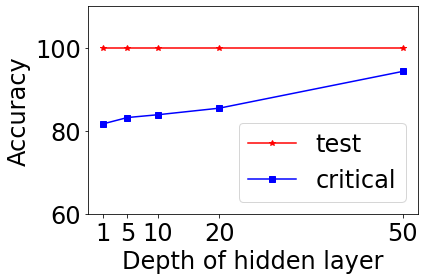

In [8]:
from matplotlib import pyplot as plt

## Print the result for different N
%matplotlib inline

plt.plot(N_array, test_array, 'r-*', label="test")
plt.plot(N_array, critical_array, 'b-s', label="critical")
plt.ylim(60,110)
plt.xlabel('Depth of hidden layer', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()


# It was not very clear what is stride function is in Metha and Notebook, but after read this website would help people understand what question 2 is asking: https://cs231n.github.io/convolutional-networks/. Where I found stride is a 

# Three hyperparameters control the size of the output volume: the depth, stride and zero-padding

# We must specify the stride with which we slide the filter. When the stride is 1 then we move the filters one pixel at a time. When the stride is 2 then the filters jump 2 pixels at a time as we slide them around. This will produce smaller output volumes spatially.

In [33]:
import torch.nn as nn # construct NN

class model(nn.Module):
    # create convolutional net
    def __init__(self, N=10, L=40):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()	
        # create convolutional layer with input depth 1 and output depth N
        self.conv1 = nn.Conv2d(1, N, kernel_size=2,stride=1, padding=1)
        # batch norm layer takes Depth
        self.bn1=nn.BatchNorm2d(N) 
        # create fully connected layer after maxpool operation reduced 40->18
        self.fc1 = nn.Linear(20*20*N, 2) 	
        self.N=N
        self.L=L
        print("The number of neurons in CNN layer is %i"%(N))

    def forward(self, x):
        #Unsqueeze command indicates one channel and turns x.shape from (:,40,40) to (:,1, 40,40)
        x=F.relu(self.conv1(torch.unsqueeze(x,1).float()))
        #print(x.shape)  often useful to look at shapes for debugging
        x = F.max_pool2d(x,2)	 
        #print(x.shape)
        x=self.bn1(x) # largely unnecessary and here just for pedagogical purposes
        return F.log_softmax(self.fc1(x.view(-1,20*20*self.N)), dim=1)


In [34]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# training settings
parser = argparse.ArgumentParser(description='PyTorch Convmodel Ising Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.epochs=5
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

cuda_kwargs = {'num_workers': 0, 'pin_memory': True} if args.cuda else {}

import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

# load data
train_loader, test_loader, critical_loader=load_data(cuda_kwargs)

test_array=[]
critical_array=[]

# create array of depth of convolutional layer
N_array=[1,5,10,20,50]

# loop over depths
for N in N_array:
    CNN = model(N=N)
    if args.cuda:
        CNN.cuda()

    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(CNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(CNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    # train the CNN and test its performance at each epoch
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        if epoch==args.epochs:
            test_array.append(test(test_loader,verbose='Test'))
            critical_array.append(test(critical_loader,verbose='Critical'))
        else:
            test(test_loader,verbose='Test')
            test(critical_loader,verbose='Critical')
    print(test_array)
    print(critical_array)

Finished loading data
Training on 80 percent of examples
Finished loading data
Testing on 20 percent of examples
Finished loading data
Predicting on 30000 critical examples
The number of neurons in CNN layer is 1
Train Epoch: 1 [0/104000 (0%)]	Loss: 0.757566
Train Epoch: 1 [640/104000 (1%)]	Loss: 0.391262
Train Epoch: 1 [1280/104000 (1%)]	Loss: 0.257068
Train Epoch: 1 [1920/104000 (2%)]	Loss: 0.194598
Train Epoch: 1 [2560/104000 (2%)]	Loss: 0.148262
Train Epoch: 1 [3200/104000 (3%)]	Loss: 0.108639
Train Epoch: 1 [3840/104000 (4%)]	Loss: 0.148370
Train Epoch: 1 [4480/104000 (4%)]	Loss: 0.086584
Train Epoch: 1 [5120/104000 (5%)]	Loss: 0.064565
Train Epoch: 1 [5760/104000 (6%)]	Loss: 0.085000
Train Epoch: 1 [6400/104000 (6%)]	Loss: 0.048992
Train Epoch: 1 [7040/104000 (7%)]	Loss: 0.043759
Train Epoch: 1 [7680/104000 (7%)]	Loss: 0.061685
Train Epoch: 1 [8320/104000 (8%)]	Loss: 0.041314
Train Epoch: 1 [8960/104000 (9%)]	Loss: 0.062052
Train Epoch: 1 [9600/104000 (9%)]	Loss: 0.037984
Train E

Train Epoch: 1 [101120/104000 (97%)]	Loss: 0.003462
Train Epoch: 1 [101760/104000 (98%)]	Loss: 0.006331
Train Epoch: 1 [102400/104000 (98%)]	Loss: 0.002271
Train Epoch: 1 [103040/104000 (99%)]	Loss: 0.005162
Train Epoch: 1 [103680/104000 (100%)]	Loss: 0.002341

Test set: Average loss: 0.0046, Accuracy: 25998/26000 (100%)


Critical set: Average loss: 0.6509, Accuracy: 23318/30000 (78%)

Train Epoch: 2 [0/104000 (0%)]	Loss: 0.033140
Train Epoch: 2 [640/104000 (1%)]	Loss: 0.004281
Train Epoch: 2 [1280/104000 (1%)]	Loss: 0.006712
Train Epoch: 2 [1920/104000 (2%)]	Loss: 0.004844
Train Epoch: 2 [2560/104000 (2%)]	Loss: 0.002781
Train Epoch: 2 [3200/104000 (3%)]	Loss: 0.011431
Train Epoch: 2 [3840/104000 (4%)]	Loss: 0.009536
Train Epoch: 2 [4480/104000 (4%)]	Loss: 0.006012
Train Epoch: 2 [5120/104000 (5%)]	Loss: 0.005145
Train Epoch: 2 [5760/104000 (6%)]	Loss: 0.011609
Train Epoch: 2 [6400/104000 (6%)]	Loss: 0.003022
Train Epoch: 2 [7040/104000 (7%)]	Loss: 0.002715
Train Epoch: 2 [7680/10400

Train Epoch: 2 [99200/104000 (95%)]	Loss: 0.001272
Train Epoch: 2 [99840/104000 (96%)]	Loss: 0.013563
Train Epoch: 2 [100480/104000 (97%)]	Loss: 0.000827
Train Epoch: 2 [101120/104000 (97%)]	Loss: 0.002803
Train Epoch: 2 [101760/104000 (98%)]	Loss: 0.024816
Train Epoch: 2 [102400/104000 (98%)]	Loss: 0.003359
Train Epoch: 2 [103040/104000 (99%)]	Loss: 0.000985
Train Epoch: 2 [103680/104000 (100%)]	Loss: 0.002762

Test set: Average loss: 0.0024, Accuracy: 25998/26000 (100%)


Critical set: Average loss: 0.6700, Accuracy: 23650/30000 (79%)

Train Epoch: 3 [0/104000 (0%)]	Loss: 0.001759
Train Epoch: 3 [640/104000 (1%)]	Loss: 0.001418
Train Epoch: 3 [1280/104000 (1%)]	Loss: 0.003698
Train Epoch: 3 [1920/104000 (2%)]	Loss: 0.004986
Train Epoch: 3 [2560/104000 (2%)]	Loss: 0.001646
Train Epoch: 3 [3200/104000 (3%)]	Loss: 0.004920
Train Epoch: 3 [3840/104000 (4%)]	Loss: 0.002666
Train Epoch: 3 [4480/104000 (4%)]	Loss: 0.002875
Train Epoch: 3 [5120/104000 (5%)]	Loss: 0.001612
Train Epoch: 3 [576

Train Epoch: 3 [97920/104000 (94%)]	Loss: 0.003658
Train Epoch: 3 [98560/104000 (95%)]	Loss: 0.000762
Train Epoch: 3 [99200/104000 (95%)]	Loss: 0.000398
Train Epoch: 3 [99840/104000 (96%)]	Loss: 0.000720
Train Epoch: 3 [100480/104000 (97%)]	Loss: 0.001397
Train Epoch: 3 [101120/104000 (97%)]	Loss: 0.001802
Train Epoch: 3 [101760/104000 (98%)]	Loss: 0.001784
Train Epoch: 3 [102400/104000 (98%)]	Loss: 0.001062
Train Epoch: 3 [103040/104000 (99%)]	Loss: 0.002507
Train Epoch: 3 [103680/104000 (100%)]	Loss: 0.005974

Test set: Average loss: 0.0017, Accuracy: 25998/26000 (100%)


Critical set: Average loss: 0.7240, Accuracy: 23613/30000 (79%)

Train Epoch: 4 [0/104000 (0%)]	Loss: 0.004717
Train Epoch: 4 [640/104000 (1%)]	Loss: 0.000554
Train Epoch: 4 [1280/104000 (1%)]	Loss: 0.000565
Train Epoch: 4 [1920/104000 (2%)]	Loss: 0.002769
Train Epoch: 4 [2560/104000 (2%)]	Loss: 0.001148
Train Epoch: 4 [3200/104000 (3%)]	Loss: 0.001823
Train Epoch: 4 [3840/104000 (4%)]	Loss: 0.001657
Train Epoch: 4 

Train Epoch: 4 [96000/104000 (92%)]	Loss: 0.002312
Train Epoch: 4 [96640/104000 (93%)]	Loss: 0.002567
Train Epoch: 4 [97280/104000 (94%)]	Loss: 0.000793
Train Epoch: 4 [97920/104000 (94%)]	Loss: 0.002089
Train Epoch: 4 [98560/104000 (95%)]	Loss: 0.002015
Train Epoch: 4 [99200/104000 (95%)]	Loss: 0.000533
Train Epoch: 4 [99840/104000 (96%)]	Loss: 0.006187
Train Epoch: 4 [100480/104000 (97%)]	Loss: 0.000828
Train Epoch: 4 [101120/104000 (97%)]	Loss: 0.001011
Train Epoch: 4 [101760/104000 (98%)]	Loss: 0.001240
Train Epoch: 4 [102400/104000 (98%)]	Loss: 0.000929
Train Epoch: 4 [103040/104000 (99%)]	Loss: 0.000417
Train Epoch: 4 [103680/104000 (100%)]	Loss: 0.001258

Test set: Average loss: 0.0013, Accuracy: 25998/26000 (100%)


Critical set: Average loss: 0.7237, Accuracy: 23745/30000 (79%)

Train Epoch: 5 [0/104000 (0%)]	Loss: 0.000665
Train Epoch: 5 [640/104000 (1%)]	Loss: 0.010657
Train Epoch: 5 [1280/104000 (1%)]	Loss: 0.001964
Train Epoch: 5 [1920/104000 (2%)]	Loss: 0.001636
Train Epo

Train Epoch: 5 [93440/104000 (90%)]	Loss: 0.002428
Train Epoch: 5 [94080/104000 (90%)]	Loss: 0.002007
Train Epoch: 5 [94720/104000 (91%)]	Loss: 0.000288
Train Epoch: 5 [95360/104000 (92%)]	Loss: 0.000647
Train Epoch: 5 [96000/104000 (92%)]	Loss: 0.001071
Train Epoch: 5 [96640/104000 (93%)]	Loss: 0.000921
Train Epoch: 5 [97280/104000 (94%)]	Loss: 0.000393
Train Epoch: 5 [97920/104000 (94%)]	Loss: 0.001231
Train Epoch: 5 [98560/104000 (95%)]	Loss: 0.003692
Train Epoch: 5 [99200/104000 (95%)]	Loss: 0.000637
Train Epoch: 5 [99840/104000 (96%)]	Loss: 0.000224
Train Epoch: 5 [100480/104000 (97%)]	Loss: 0.001779
Train Epoch: 5 [101120/104000 (97%)]	Loss: 0.000449
Train Epoch: 5 [101760/104000 (98%)]	Loss: 0.003467
Train Epoch: 5 [102400/104000 (98%)]	Loss: 0.000460
Train Epoch: 5 [103040/104000 (99%)]	Loss: 0.004127
Train Epoch: 5 [103680/104000 (100%)]	Loss: 0.003668

Test set: Average loss: 0.0010, Accuracy: 25999/26000 (100%)


Critical set: Average loss: 0.8313, Accuracy: 23438/30000 (78%

Train Epoch: 1 [90880/104000 (87%)]	Loss: 0.000601
Train Epoch: 1 [91520/104000 (88%)]	Loss: 0.001222
Train Epoch: 1 [92160/104000 (89%)]	Loss: 0.000323
Train Epoch: 1 [92800/104000 (89%)]	Loss: 0.000862
Train Epoch: 1 [93440/104000 (90%)]	Loss: 0.000731
Train Epoch: 1 [94080/104000 (90%)]	Loss: 0.000221
Train Epoch: 1 [94720/104000 (91%)]	Loss: 0.000781
Train Epoch: 1 [95360/104000 (92%)]	Loss: 0.001276
Train Epoch: 1 [96000/104000 (92%)]	Loss: 0.000327
Train Epoch: 1 [96640/104000 (93%)]	Loss: 0.000450
Train Epoch: 1 [97280/104000 (94%)]	Loss: 0.010067
Train Epoch: 1 [97920/104000 (94%)]	Loss: 0.002135
Train Epoch: 1 [98560/104000 (95%)]	Loss: 0.000428
Train Epoch: 1 [99200/104000 (95%)]	Loss: 0.000594
Train Epoch: 1 [99840/104000 (96%)]	Loss: 0.000256
Train Epoch: 1 [100480/104000 (97%)]	Loss: 0.000382
Train Epoch: 1 [101120/104000 (97%)]	Loss: 0.000192
Train Epoch: 1 [101760/104000 (98%)]	Loss: 0.000285
Train Epoch: 1 [102400/104000 (98%)]	Loss: 0.000278
Train Epoch: 1 [103040/1040

Train Epoch: 2 [88320/104000 (85%)]	Loss: 0.000483
Train Epoch: 2 [88960/104000 (86%)]	Loss: 0.000252
Train Epoch: 2 [89600/104000 (86%)]	Loss: 0.000482
Train Epoch: 2 [90240/104000 (87%)]	Loss: 0.001468
Train Epoch: 2 [90880/104000 (87%)]	Loss: 0.000180
Train Epoch: 2 [91520/104000 (88%)]	Loss: 0.000336
Train Epoch: 2 [92160/104000 (89%)]	Loss: 0.000148
Train Epoch: 2 [92800/104000 (89%)]	Loss: 0.000196
Train Epoch: 2 [93440/104000 (90%)]	Loss: 0.000098
Train Epoch: 2 [94080/104000 (90%)]	Loss: 0.000371
Train Epoch: 2 [94720/104000 (91%)]	Loss: 0.000175
Train Epoch: 2 [95360/104000 (92%)]	Loss: 0.000346
Train Epoch: 2 [96000/104000 (92%)]	Loss: 0.000504
Train Epoch: 2 [96640/104000 (93%)]	Loss: 0.000465
Train Epoch: 2 [97280/104000 (94%)]	Loss: 0.000364
Train Epoch: 2 [97920/104000 (94%)]	Loss: 0.000442
Train Epoch: 2 [98560/104000 (95%)]	Loss: 0.000618
Train Epoch: 2 [99200/104000 (95%)]	Loss: 0.000152
Train Epoch: 2 [99840/104000 (96%)]	Loss: 0.000357
Train Epoch: 2 [100480/104000 (

Train Epoch: 3 [85760/104000 (82%)]	Loss: 0.000068
Train Epoch: 3 [86400/104000 (83%)]	Loss: 0.000241
Train Epoch: 3 [87040/104000 (84%)]	Loss: 0.000467
Train Epoch: 3 [87680/104000 (84%)]	Loss: 0.000507
Train Epoch: 3 [88320/104000 (85%)]	Loss: 0.001115
Train Epoch: 3 [88960/104000 (86%)]	Loss: 0.000069
Train Epoch: 3 [89600/104000 (86%)]	Loss: 0.000141
Train Epoch: 3 [90240/104000 (87%)]	Loss: 0.000981
Train Epoch: 3 [90880/104000 (87%)]	Loss: 0.000134
Train Epoch: 3 [91520/104000 (88%)]	Loss: 0.000329
Train Epoch: 3 [92160/104000 (89%)]	Loss: 0.000195
Train Epoch: 3 [92800/104000 (89%)]	Loss: 0.000073
Train Epoch: 3 [93440/104000 (90%)]	Loss: 0.000147
Train Epoch: 3 [94080/104000 (90%)]	Loss: 0.000254
Train Epoch: 3 [94720/104000 (91%)]	Loss: 0.000152
Train Epoch: 3 [95360/104000 (92%)]	Loss: 0.000303
Train Epoch: 3 [96000/104000 (92%)]	Loss: 0.000126
Train Epoch: 3 [96640/104000 (93%)]	Loss: 0.000783
Train Epoch: 3 [97280/104000 (94%)]	Loss: 0.000184
Train Epoch: 3 [97920/104000 (9

Train Epoch: 4 [83200/104000 (80%)]	Loss: 0.000104
Train Epoch: 4 [83840/104000 (81%)]	Loss: 0.000332
Train Epoch: 4 [84480/104000 (81%)]	Loss: 0.000156
Train Epoch: 4 [85120/104000 (82%)]	Loss: 0.000475
Train Epoch: 4 [85760/104000 (82%)]	Loss: 0.000250
Train Epoch: 4 [86400/104000 (83%)]	Loss: 0.000174
Train Epoch: 4 [87040/104000 (84%)]	Loss: 0.000525
Train Epoch: 4 [87680/104000 (84%)]	Loss: 0.000419
Train Epoch: 4 [88320/104000 (85%)]	Loss: 0.000100
Train Epoch: 4 [88960/104000 (86%)]	Loss: 0.000372
Train Epoch: 4 [89600/104000 (86%)]	Loss: 0.000434
Train Epoch: 4 [90240/104000 (87%)]	Loss: 0.000080
Train Epoch: 4 [90880/104000 (87%)]	Loss: 0.000259
Train Epoch: 4 [91520/104000 (88%)]	Loss: 0.000184
Train Epoch: 4 [92160/104000 (89%)]	Loss: 0.000155
Train Epoch: 4 [92800/104000 (89%)]	Loss: 0.000141
Train Epoch: 4 [93440/104000 (90%)]	Loss: 0.000498
Train Epoch: 4 [94080/104000 (90%)]	Loss: 0.000076
Train Epoch: 4 [94720/104000 (91%)]	Loss: 0.000222
Train Epoch: 4 [95360/104000 (9

Train Epoch: 5 [81280/104000 (78%)]	Loss: 0.000085
Train Epoch: 5 [81920/104000 (79%)]	Loss: 0.000034
Train Epoch: 5 [82560/104000 (79%)]	Loss: 0.000494
Train Epoch: 5 [83200/104000 (80%)]	Loss: 0.000071
Train Epoch: 5 [83840/104000 (81%)]	Loss: 0.000108
Train Epoch: 5 [84480/104000 (81%)]	Loss: 0.000130
Train Epoch: 5 [85120/104000 (82%)]	Loss: 0.000215
Train Epoch: 5 [85760/104000 (82%)]	Loss: 0.000073
Train Epoch: 5 [86400/104000 (83%)]	Loss: 0.000022
Train Epoch: 5 [87040/104000 (84%)]	Loss: 0.000146
Train Epoch: 5 [87680/104000 (84%)]	Loss: 0.000302
Train Epoch: 5 [88320/104000 (85%)]	Loss: 0.000095
Train Epoch: 5 [88960/104000 (86%)]	Loss: 0.000032
Train Epoch: 5 [89600/104000 (86%)]	Loss: 0.000136
Train Epoch: 5 [90240/104000 (87%)]	Loss: 0.000065
Train Epoch: 5 [90880/104000 (87%)]	Loss: 0.000071
Train Epoch: 5 [91520/104000 (88%)]	Loss: 0.000059
Train Epoch: 5 [92160/104000 (89%)]	Loss: 0.000063
Train Epoch: 5 [92800/104000 (89%)]	Loss: 0.000067
Train Epoch: 5 [93440/104000 (9

Train Epoch: 1 [77440/104000 (74%)]	Loss: 0.000432
Train Epoch: 1 [78080/104000 (75%)]	Loss: 0.000349
Train Epoch: 1 [78720/104000 (76%)]	Loss: 0.000219
Train Epoch: 1 [79360/104000 (76%)]	Loss: 0.000152
Train Epoch: 1 [80000/104000 (77%)]	Loss: 0.001990
Train Epoch: 1 [80640/104000 (78%)]	Loss: 0.000358
Train Epoch: 1 [81280/104000 (78%)]	Loss: 0.000331
Train Epoch: 1 [81920/104000 (79%)]	Loss: 0.000249
Train Epoch: 1 [82560/104000 (79%)]	Loss: 0.000534
Train Epoch: 1 [83200/104000 (80%)]	Loss: 0.000286
Train Epoch: 1 [83840/104000 (81%)]	Loss: 0.000763
Train Epoch: 1 [84480/104000 (81%)]	Loss: 0.000330
Train Epoch: 1 [85120/104000 (82%)]	Loss: 0.000452
Train Epoch: 1 [85760/104000 (82%)]	Loss: 0.001133
Train Epoch: 1 [86400/104000 (83%)]	Loss: 0.000246
Train Epoch: 1 [87040/104000 (84%)]	Loss: 0.000313
Train Epoch: 1 [87680/104000 (84%)]	Loss: 0.000399
Train Epoch: 1 [88320/104000 (85%)]	Loss: 0.000320
Train Epoch: 1 [88960/104000 (86%)]	Loss: 0.002008
Train Epoch: 1 [89600/104000 (8

Train Epoch: 2 [74880/104000 (72%)]	Loss: 0.000579
Train Epoch: 2 [75520/104000 (73%)]	Loss: 0.000110
Train Epoch: 2 [76160/104000 (73%)]	Loss: 0.000076
Train Epoch: 2 [76800/104000 (74%)]	Loss: 0.000126
Train Epoch: 2 [77440/104000 (74%)]	Loss: 0.000158
Train Epoch: 2 [78080/104000 (75%)]	Loss: 0.000196
Train Epoch: 2 [78720/104000 (76%)]	Loss: 0.000147
Train Epoch: 2 [79360/104000 (76%)]	Loss: 0.000309
Train Epoch: 2 [80000/104000 (77%)]	Loss: 0.000130
Train Epoch: 2 [80640/104000 (78%)]	Loss: 0.000136
Train Epoch: 2 [81280/104000 (78%)]	Loss: 0.000113
Train Epoch: 2 [81920/104000 (79%)]	Loss: 0.000633
Train Epoch: 2 [82560/104000 (79%)]	Loss: 0.000242
Train Epoch: 2 [83200/104000 (80%)]	Loss: 0.001798
Train Epoch: 2 [83840/104000 (81%)]	Loss: 0.000236
Train Epoch: 2 [84480/104000 (81%)]	Loss: 0.000137
Train Epoch: 2 [85120/104000 (82%)]	Loss: 0.000545
Train Epoch: 2 [85760/104000 (82%)]	Loss: 0.000072
Train Epoch: 2 [86400/104000 (83%)]	Loss: 0.000375
Train Epoch: 2 [87040/104000 (8

Train Epoch: 3 [72320/104000 (70%)]	Loss: 0.000093
Train Epoch: 3 [72960/104000 (70%)]	Loss: 0.000319
Train Epoch: 3 [73600/104000 (71%)]	Loss: 0.000345
Train Epoch: 3 [74240/104000 (71%)]	Loss: 0.000247
Train Epoch: 3 [74880/104000 (72%)]	Loss: 0.000207
Train Epoch: 3 [75520/104000 (73%)]	Loss: 0.000246
Train Epoch: 3 [76160/104000 (73%)]	Loss: 0.000070
Train Epoch: 3 [76800/104000 (74%)]	Loss: 0.000090
Train Epoch: 3 [77440/104000 (74%)]	Loss: 0.000142
Train Epoch: 3 [78080/104000 (75%)]	Loss: 0.000076
Train Epoch: 3 [78720/104000 (76%)]	Loss: 0.000083
Train Epoch: 3 [79360/104000 (76%)]	Loss: 0.000057
Train Epoch: 3 [80000/104000 (77%)]	Loss: 0.000055
Train Epoch: 3 [80640/104000 (78%)]	Loss: 0.000499
Train Epoch: 3 [81280/104000 (78%)]	Loss: 0.000062
Train Epoch: 3 [81920/104000 (79%)]	Loss: 0.000628
Train Epoch: 3 [82560/104000 (79%)]	Loss: 0.000068
Train Epoch: 3 [83200/104000 (80%)]	Loss: 0.000138
Train Epoch: 3 [83840/104000 (81%)]	Loss: 0.000079
Train Epoch: 3 [84480/104000 (8

Train Epoch: 4 [69760/104000 (67%)]	Loss: 0.000443
Train Epoch: 4 [70400/104000 (68%)]	Loss: 0.000081
Train Epoch: 4 [71040/104000 (68%)]	Loss: 0.000032
Train Epoch: 4 [71680/104000 (69%)]	Loss: 0.000163
Train Epoch: 4 [72320/104000 (70%)]	Loss: 0.000097
Train Epoch: 4 [72960/104000 (70%)]	Loss: 0.000051
Train Epoch: 4 [73600/104000 (71%)]	Loss: 0.000039
Train Epoch: 4 [74240/104000 (71%)]	Loss: 0.000044
Train Epoch: 4 [74880/104000 (72%)]	Loss: 0.000112
Train Epoch: 4 [75520/104000 (73%)]	Loss: 0.000042
Train Epoch: 4 [76160/104000 (73%)]	Loss: 0.000261
Train Epoch: 4 [76800/104000 (74%)]	Loss: 0.000026
Train Epoch: 4 [77440/104000 (74%)]	Loss: 0.000123
Train Epoch: 4 [78080/104000 (75%)]	Loss: 0.000059
Train Epoch: 4 [78720/104000 (76%)]	Loss: 0.000059
Train Epoch: 4 [79360/104000 (76%)]	Loss: 0.000041
Train Epoch: 4 [80000/104000 (77%)]	Loss: 0.000082
Train Epoch: 4 [80640/104000 (78%)]	Loss: 0.000057
Train Epoch: 4 [81280/104000 (78%)]	Loss: 0.000068
Train Epoch: 4 [81920/104000 (7

Train Epoch: 5 [67200/104000 (65%)]	Loss: 0.000079
Train Epoch: 5 [67840/104000 (65%)]	Loss: 0.000143
Train Epoch: 5 [68480/104000 (66%)]	Loss: 0.000123
Train Epoch: 5 [69120/104000 (66%)]	Loss: 0.000051
Train Epoch: 5 [69760/104000 (67%)]	Loss: 0.000048
Train Epoch: 5 [70400/104000 (68%)]	Loss: 0.000084
Train Epoch: 5 [71040/104000 (68%)]	Loss: 0.000071
Train Epoch: 5 [71680/104000 (69%)]	Loss: 0.000057
Train Epoch: 5 [72320/104000 (70%)]	Loss: 0.000142
Train Epoch: 5 [72960/104000 (70%)]	Loss: 0.000034
Train Epoch: 5 [73600/104000 (71%)]	Loss: 0.000063
Train Epoch: 5 [74240/104000 (71%)]	Loss: 0.000056
Train Epoch: 5 [74880/104000 (72%)]	Loss: 0.000108
Train Epoch: 5 [75520/104000 (73%)]	Loss: 0.000340
Train Epoch: 5 [76160/104000 (73%)]	Loss: 0.001170
Train Epoch: 5 [76800/104000 (74%)]	Loss: 0.000049
Train Epoch: 5 [77440/104000 (74%)]	Loss: 0.000068
Train Epoch: 5 [78080/104000 (75%)]	Loss: 0.000028
Train Epoch: 5 [78720/104000 (76%)]	Loss: 0.000037
Train Epoch: 5 [79360/104000 (7

Train Epoch: 1 [63360/104000 (61%)]	Loss: 0.000132
Train Epoch: 1 [64000/104000 (62%)]	Loss: 0.000139
Train Epoch: 1 [64640/104000 (62%)]	Loss: 0.000127
Train Epoch: 1 [65280/104000 (63%)]	Loss: 0.000100
Train Epoch: 1 [65920/104000 (63%)]	Loss: 0.000128
Train Epoch: 1 [66560/104000 (64%)]	Loss: 0.000183
Train Epoch: 1 [67200/104000 (65%)]	Loss: 0.000096
Train Epoch: 1 [67840/104000 (65%)]	Loss: 0.000090
Train Epoch: 1 [68480/104000 (66%)]	Loss: 0.000235
Train Epoch: 1 [69120/104000 (66%)]	Loss: 0.000237
Train Epoch: 1 [69760/104000 (67%)]	Loss: 0.000136
Train Epoch: 1 [70400/104000 (68%)]	Loss: 0.000129
Train Epoch: 1 [71040/104000 (68%)]	Loss: 0.000189
Train Epoch: 1 [71680/104000 (69%)]	Loss: 0.000242
Train Epoch: 1 [72320/104000 (70%)]	Loss: 0.000114
Train Epoch: 1 [72960/104000 (70%)]	Loss: 0.000143
Train Epoch: 1 [73600/104000 (71%)]	Loss: 0.000320
Train Epoch: 1 [74240/104000 (71%)]	Loss: 0.000099
Train Epoch: 1 [74880/104000 (72%)]	Loss: 0.001340
Train Epoch: 1 [75520/104000 (7

Train Epoch: 2 [60800/104000 (58%)]	Loss: 0.000034
Train Epoch: 2 [61440/104000 (59%)]	Loss: 0.000155
Train Epoch: 2 [62080/104000 (60%)]	Loss: 0.000066
Train Epoch: 2 [62720/104000 (60%)]	Loss: 0.000060
Train Epoch: 2 [63360/104000 (61%)]	Loss: 0.000346
Train Epoch: 2 [64000/104000 (62%)]	Loss: 0.000045
Train Epoch: 2 [64640/104000 (62%)]	Loss: 0.000141
Train Epoch: 2 [65280/104000 (63%)]	Loss: 0.000031
Train Epoch: 2 [65920/104000 (63%)]	Loss: 0.000062
Train Epoch: 2 [66560/104000 (64%)]	Loss: 0.000053
Train Epoch: 2 [67200/104000 (65%)]	Loss: 0.000151
Train Epoch: 2 [67840/104000 (65%)]	Loss: 0.000310
Train Epoch: 2 [68480/104000 (66%)]	Loss: 0.000049
Train Epoch: 2 [69120/104000 (66%)]	Loss: 0.000196
Train Epoch: 2 [69760/104000 (67%)]	Loss: 0.000063
Train Epoch: 2 [70400/104000 (68%)]	Loss: 0.000086
Train Epoch: 2 [71040/104000 (68%)]	Loss: 0.000082
Train Epoch: 2 [71680/104000 (69%)]	Loss: 0.000082
Train Epoch: 2 [72320/104000 (70%)]	Loss: 0.000166
Train Epoch: 2 [72960/104000 (7

Train Epoch: 3 [58240/104000 (56%)]	Loss: 0.000222
Train Epoch: 3 [58880/104000 (57%)]	Loss: 0.000094
Train Epoch: 3 [59520/104000 (57%)]	Loss: 0.000037
Train Epoch: 3 [60160/104000 (58%)]	Loss: 0.000035
Train Epoch: 3 [60800/104000 (58%)]	Loss: 0.000059
Train Epoch: 3 [61440/104000 (59%)]	Loss: 0.000049
Train Epoch: 3 [62080/104000 (60%)]	Loss: 0.000052
Train Epoch: 3 [62720/104000 (60%)]	Loss: 0.000033
Train Epoch: 3 [63360/104000 (61%)]	Loss: 0.000044
Train Epoch: 3 [64000/104000 (62%)]	Loss: 0.000040
Train Epoch: 3 [64640/104000 (62%)]	Loss: 0.000120
Train Epoch: 3 [65280/104000 (63%)]	Loss: 0.000174
Train Epoch: 3 [65920/104000 (63%)]	Loss: 0.000349
Train Epoch: 3 [66560/104000 (64%)]	Loss: 0.000064
Train Epoch: 3 [67200/104000 (65%)]	Loss: 0.000095
Train Epoch: 3 [67840/104000 (65%)]	Loss: 0.000023
Train Epoch: 3 [68480/104000 (66%)]	Loss: 0.000035
Train Epoch: 3 [69120/104000 (66%)]	Loss: 0.000017
Train Epoch: 3 [69760/104000 (67%)]	Loss: 0.000046
Train Epoch: 3 [70400/104000 (6

Train Epoch: 4 [55680/104000 (54%)]	Loss: 0.000078
Train Epoch: 4 [56320/104000 (54%)]	Loss: 0.000089
Train Epoch: 4 [56960/104000 (55%)]	Loss: 0.000023
Train Epoch: 4 [57600/104000 (55%)]	Loss: 0.000030
Train Epoch: 4 [58240/104000 (56%)]	Loss: 0.000159
Train Epoch: 4 [58880/104000 (57%)]	Loss: 0.000024
Train Epoch: 4 [59520/104000 (57%)]	Loss: 0.000262
Train Epoch: 4 [60160/104000 (58%)]	Loss: 0.000056
Train Epoch: 4 [60800/104000 (58%)]	Loss: 0.000033
Train Epoch: 4 [61440/104000 (59%)]	Loss: 0.000164
Train Epoch: 4 [62080/104000 (60%)]	Loss: 0.000039
Train Epoch: 4 [62720/104000 (60%)]	Loss: 0.000024
Train Epoch: 4 [63360/104000 (61%)]	Loss: 0.000019
Train Epoch: 4 [64000/104000 (62%)]	Loss: 0.000018
Train Epoch: 4 [64640/104000 (62%)]	Loss: 0.000058
Train Epoch: 4 [65280/104000 (63%)]	Loss: 0.000025
Train Epoch: 4 [65920/104000 (63%)]	Loss: 0.000069
Train Epoch: 4 [66560/104000 (64%)]	Loss: 0.000015
Train Epoch: 4 [67200/104000 (65%)]	Loss: 0.000013
Train Epoch: 4 [67840/104000 (6

Train Epoch: 5 [53120/104000 (51%)]	Loss: 0.000188
Train Epoch: 5 [53760/104000 (52%)]	Loss: 0.000017
Train Epoch: 5 [54400/104000 (52%)]	Loss: 0.000074
Train Epoch: 5 [55040/104000 (53%)]	Loss: 0.000053
Train Epoch: 5 [55680/104000 (54%)]	Loss: 0.000033
Train Epoch: 5 [56320/104000 (54%)]	Loss: 0.000243
Train Epoch: 5 [56960/104000 (55%)]	Loss: 0.000087
Train Epoch: 5 [57600/104000 (55%)]	Loss: 0.000064
Train Epoch: 5 [58240/104000 (56%)]	Loss: 0.000027
Train Epoch: 5 [58880/104000 (57%)]	Loss: 0.000014
Train Epoch: 5 [59520/104000 (57%)]	Loss: 0.000044
Train Epoch: 5 [60160/104000 (58%)]	Loss: 0.000023
Train Epoch: 5 [60800/104000 (58%)]	Loss: 0.000015
Train Epoch: 5 [61440/104000 (59%)]	Loss: 0.000014
Train Epoch: 5 [62080/104000 (60%)]	Loss: 0.000021
Train Epoch: 5 [62720/104000 (60%)]	Loss: 0.000031
Train Epoch: 5 [63360/104000 (61%)]	Loss: 0.000068
Train Epoch: 5 [64000/104000 (62%)]	Loss: 0.000009
Train Epoch: 5 [64640/104000 (62%)]	Loss: 0.000035
Train Epoch: 5 [65280/104000 (6

Train Epoch: 1 [48640/104000 (47%)]	Loss: 0.000011
Train Epoch: 1 [49280/104000 (47%)]	Loss: 0.000101
Train Epoch: 1 [49920/104000 (48%)]	Loss: 0.000030
Train Epoch: 1 [50560/104000 (49%)]	Loss: 0.000011
Train Epoch: 1 [51200/104000 (49%)]	Loss: 0.000084
Train Epoch: 1 [51840/104000 (50%)]	Loss: 0.000040
Train Epoch: 1 [52480/104000 (50%)]	Loss: 0.000056
Train Epoch: 1 [53120/104000 (51%)]	Loss: 0.000066
Train Epoch: 1 [53760/104000 (52%)]	Loss: 0.000074
Train Epoch: 1 [54400/104000 (52%)]	Loss: 0.000034
Train Epoch: 1 [55040/104000 (53%)]	Loss: 0.000015
Train Epoch: 1 [55680/104000 (54%)]	Loss: 0.000010
Train Epoch: 1 [56320/104000 (54%)]	Loss: 0.000012
Train Epoch: 1 [56960/104000 (55%)]	Loss: 0.000073
Train Epoch: 1 [57600/104000 (55%)]	Loss: 0.000096
Train Epoch: 1 [58240/104000 (56%)]	Loss: 0.000046
Train Epoch: 1 [58880/104000 (57%)]	Loss: 0.000026
Train Epoch: 1 [59520/104000 (57%)]	Loss: 0.000025
Train Epoch: 1 [60160/104000 (58%)]	Loss: 0.000027
Train Epoch: 1 [60800/104000 (5

Train Epoch: 2 [46080/104000 (44%)]	Loss: 0.000010
Train Epoch: 2 [46720/104000 (45%)]	Loss: 0.000007
Train Epoch: 2 [47360/104000 (46%)]	Loss: 0.000012
Train Epoch: 2 [48000/104000 (46%)]	Loss: 0.000023
Train Epoch: 2 [48640/104000 (47%)]	Loss: 0.000020
Train Epoch: 2 [49280/104000 (47%)]	Loss: 0.000013
Train Epoch: 2 [49920/104000 (48%)]	Loss: 0.000010
Train Epoch: 2 [50560/104000 (49%)]	Loss: 0.000014
Train Epoch: 2 [51200/104000 (49%)]	Loss: 0.000036
Train Epoch: 2 [51840/104000 (50%)]	Loss: 0.000009
Train Epoch: 2 [52480/104000 (50%)]	Loss: 0.000009
Train Epoch: 2 [53120/104000 (51%)]	Loss: 0.000010
Train Epoch: 2 [53760/104000 (52%)]	Loss: 0.000005
Train Epoch: 2 [54400/104000 (52%)]	Loss: 0.000009
Train Epoch: 2 [55040/104000 (53%)]	Loss: 0.000028
Train Epoch: 2 [55680/104000 (54%)]	Loss: 0.000007
Train Epoch: 2 [56320/104000 (54%)]	Loss: 0.000011
Train Epoch: 2 [56960/104000 (55%)]	Loss: 0.000023
Train Epoch: 2 [57600/104000 (55%)]	Loss: 0.000018
Train Epoch: 2 [58240/104000 (5

Train Epoch: 3 [43520/104000 (42%)]	Loss: 0.000035
Train Epoch: 3 [44160/104000 (42%)]	Loss: 0.000019
Train Epoch: 3 [44800/104000 (43%)]	Loss: 0.000006
Train Epoch: 3 [45440/104000 (44%)]	Loss: 0.000004
Train Epoch: 3 [46080/104000 (44%)]	Loss: 0.000006
Train Epoch: 3 [46720/104000 (45%)]	Loss: 0.000025
Train Epoch: 3 [47360/104000 (46%)]	Loss: 0.000007
Train Epoch: 3 [48000/104000 (46%)]	Loss: 0.000008
Train Epoch: 3 [48640/104000 (47%)]	Loss: 0.000004
Train Epoch: 3 [49280/104000 (47%)]	Loss: 0.000027
Train Epoch: 3 [49920/104000 (48%)]	Loss: 0.000002
Train Epoch: 3 [50560/104000 (49%)]	Loss: 0.000003
Train Epoch: 3 [51200/104000 (49%)]	Loss: 0.000003
Train Epoch: 3 [51840/104000 (50%)]	Loss: 0.000012
Train Epoch: 3 [52480/104000 (50%)]	Loss: 0.000033
Train Epoch: 3 [53120/104000 (51%)]	Loss: 0.000011
Train Epoch: 3 [53760/104000 (52%)]	Loss: 0.000052
Train Epoch: 3 [54400/104000 (52%)]	Loss: 0.000005
Train Epoch: 3 [55040/104000 (53%)]	Loss: 0.000013
Train Epoch: 3 [55680/104000 (5

Train Epoch: 4 [40960/104000 (39%)]	Loss: 0.000210
Train Epoch: 4 [41600/104000 (40%)]	Loss: 0.000004
Train Epoch: 4 [42240/104000 (41%)]	Loss: 0.000046
Train Epoch: 4 [42880/104000 (41%)]	Loss: 0.000015
Train Epoch: 4 [43520/104000 (42%)]	Loss: 0.000007
Train Epoch: 4 [44160/104000 (42%)]	Loss: 0.000004
Train Epoch: 4 [44800/104000 (43%)]	Loss: 0.000009
Train Epoch: 4 [45440/104000 (44%)]	Loss: 0.000011
Train Epoch: 4 [46080/104000 (44%)]	Loss: 0.000527
Train Epoch: 4 [46720/104000 (45%)]	Loss: 0.000007
Train Epoch: 4 [47360/104000 (46%)]	Loss: 0.000001
Train Epoch: 4 [48000/104000 (46%)]	Loss: 0.000003
Train Epoch: 4 [48640/104000 (47%)]	Loss: 0.000051
Train Epoch: 4 [49280/104000 (47%)]	Loss: 0.000008
Train Epoch: 4 [49920/104000 (48%)]	Loss: 0.000003
Train Epoch: 4 [50560/104000 (49%)]	Loss: 0.000007
Train Epoch: 4 [51200/104000 (49%)]	Loss: 0.000031
Train Epoch: 4 [51840/104000 (50%)]	Loss: 0.000005
Train Epoch: 4 [52480/104000 (50%)]	Loss: 0.000020
Train Epoch: 4 [53120/104000 (5

Train Epoch: 5 [38400/104000 (37%)]	Loss: 0.000001
Train Epoch: 5 [39040/104000 (38%)]	Loss: 0.000019
Train Epoch: 5 [39680/104000 (38%)]	Loss: 0.000003
Train Epoch: 5 [40320/104000 (39%)]	Loss: 0.000004
Train Epoch: 5 [40960/104000 (39%)]	Loss: 0.000010
Train Epoch: 5 [41600/104000 (40%)]	Loss: 0.000002
Train Epoch: 5 [42240/104000 (41%)]	Loss: 0.000005
Train Epoch: 5 [42880/104000 (41%)]	Loss: 0.000005
Train Epoch: 5 [43520/104000 (42%)]	Loss: 0.000017
Train Epoch: 5 [44160/104000 (42%)]	Loss: 0.000002
Train Epoch: 5 [44800/104000 (43%)]	Loss: 0.000026
Train Epoch: 5 [45440/104000 (44%)]	Loss: 0.000010
Train Epoch: 5 [46080/104000 (44%)]	Loss: 0.000007
Train Epoch: 5 [46720/104000 (45%)]	Loss: 0.000009
Train Epoch: 5 [47360/104000 (46%)]	Loss: 0.000003
Train Epoch: 5 [48000/104000 (46%)]	Loss: 0.000010
Train Epoch: 5 [48640/104000 (47%)]	Loss: 0.000005
Train Epoch: 5 [49280/104000 (47%)]	Loss: 0.000031
Train Epoch: 5 [49920/104000 (48%)]	Loss: 0.000004
Train Epoch: 5 [50560/104000 (4

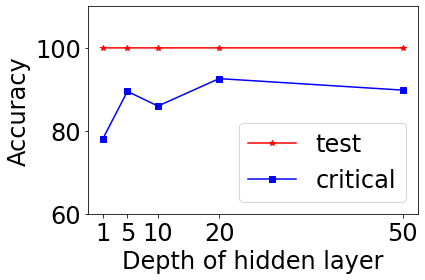

In [35]:
from matplotlib import pyplot as plt

## Print the result for different N
%matplotlib inline

plt.plot(N_array, test_array, 'r-*', label="test")
plt.plot(N_array, critical_array, 'b-s', label="critical")
plt.ylim(60,110)
plt.xlabel('Depth of hidden layer', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()


## Stride = 2, Kernel size =2, zero padding = 1 --> $H_{out}$= 10, $W_{out}$ = 10

In [42]:
import torch.nn as nn # construct NN

class model(nn.Module):
    # create convolutional net
    def __init__(self, N=10, L=40):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()	
        # create convolutional layer with input depth 1 and output depth N
        self.conv1 = nn.Conv2d(1, N, kernel_size=2,stride=2, padding=1)
        # batch norm layer takes Depth
        self.bn1=nn.BatchNorm2d(N) 
        # create fully connected layer after maxpool operation reduced 40->18
        self.fc1 = nn.Linear(10*10*N, 2) 	
        self.N=N
        self.L=L
        print("The number of neurons in CNN layer is %i"%(N))

    def forward(self, x):
        #Unsqueeze command indicates one channel and turns x.shape from (:,40,40) to (:,1, 40,40)
        x=F.relu(self.conv1(torch.unsqueeze(x,1).float()))
        #print(x.shape)  often useful to look at shapes for debugging
        x = F.max_pool2d(x,2)	 
        #print(x.shape)
        x=self.bn1(x) # largely unnecessary and here just for pedagogical purposes
        return F.log_softmax(self.fc1(x.view(-1,10*10*self.N)), dim=1)


In [43]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# training settings
parser = argparse.ArgumentParser(description='PyTorch Convmodel Ising Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.epochs=5
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

cuda_kwargs = {'num_workers': 0, 'pin_memory': True} if args.cuda else {}

import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

# load data
train_loader, test_loader, critical_loader=load_data(cuda_kwargs)

test_array=[]
critical_array=[]

# create array of depth of convolutional layer
N_array=[1,5,10,20,50]

# loop over depths
for N in N_array:
    CNN = model(N=N)
    if args.cuda:
        CNN.cuda()

    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(CNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(CNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    # train the CNN and test its performance at each epoch
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        if epoch==args.epochs:
            test_array.append(test(test_loader,verbose='Test'))
            critical_array.append(test(critical_loader,verbose='Critical'))
        else:
            test(test_loader,verbose='Test')
            test(critical_loader,verbose='Critical')
    print(test_array)
    print(critical_array)

Finished loading data
Training on 80 percent of examples
Finished loading data
Testing on 20 percent of examples
Finished loading data
Predicting on 30000 critical examples
The number of neurons in CNN layer is 1
Train Epoch: 1 [0/104000 (0%)]	Loss: 0.668288
Train Epoch: 1 [640/104000 (1%)]	Loss: 0.723359
Train Epoch: 1 [1280/104000 (1%)]	Loss: 0.570830
Train Epoch: 1 [1920/104000 (2%)]	Loss: 0.492798
Train Epoch: 1 [2560/104000 (2%)]	Loss: 0.420842
Train Epoch: 1 [3200/104000 (3%)]	Loss: 0.408276
Train Epoch: 1 [3840/104000 (4%)]	Loss: 0.427381
Train Epoch: 1 [4480/104000 (4%)]	Loss: 0.335569
Train Epoch: 1 [5120/104000 (5%)]	Loss: 0.293478
Train Epoch: 1 [5760/104000 (6%)]	Loss: 0.270613
Train Epoch: 1 [6400/104000 (6%)]	Loss: 0.234233
Train Epoch: 1 [7040/104000 (7%)]	Loss: 0.224853
Train Epoch: 1 [7680/104000 (7%)]	Loss: 0.204509
Train Epoch: 1 [8320/104000 (8%)]	Loss: 0.235366
Train Epoch: 1 [8960/104000 (9%)]	Loss: 0.188349
Train Epoch: 1 [9600/104000 (9%)]	Loss: 0.172586
Train E

Train Epoch: 1 [101760/104000 (98%)]	Loss: 0.021882
Train Epoch: 1 [102400/104000 (98%)]	Loss: 0.052608
Train Epoch: 1 [103040/104000 (99%)]	Loss: 0.013479
Train Epoch: 1 [103680/104000 (100%)]	Loss: 0.017842

Test set: Average loss: 0.0207, Accuracy: 25913/26000 (100%)


Critical set: Average loss: 0.6512, Accuracy: 22679/30000 (76%)

Train Epoch: 2 [0/104000 (0%)]	Loss: 0.053333
Train Epoch: 2 [640/104000 (1%)]	Loss: 0.045835
Train Epoch: 2 [1280/104000 (1%)]	Loss: 0.026380
Train Epoch: 2 [1920/104000 (2%)]	Loss: 0.028991
Train Epoch: 2 [2560/104000 (2%)]	Loss: 0.032552
Train Epoch: 2 [3200/104000 (3%)]	Loss: 0.017575
Train Epoch: 2 [3840/104000 (4%)]	Loss: 0.039871
Train Epoch: 2 [4480/104000 (4%)]	Loss: 0.026367
Train Epoch: 2 [5120/104000 (5%)]	Loss: 0.034607
Train Epoch: 2 [5760/104000 (6%)]	Loss: 0.015855
Train Epoch: 2 [6400/104000 (6%)]	Loss: 0.037225
Train Epoch: 2 [7040/104000 (7%)]	Loss: 0.048792
Train Epoch: 2 [7680/104000 (7%)]	Loss: 0.013372
Train Epoch: 2 [8320/104000 (

Train Epoch: 2 [100480/104000 (97%)]	Loss: 0.003775
Train Epoch: 2 [101120/104000 (97%)]	Loss: 0.000929
Train Epoch: 2 [101760/104000 (98%)]	Loss: 0.000382
Train Epoch: 2 [102400/104000 (98%)]	Loss: 0.002061
Train Epoch: 2 [103040/104000 (99%)]	Loss: 0.002457
Train Epoch: 2 [103680/104000 (100%)]	Loss: 0.001101

Test set: Average loss: 0.0010, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.4048, Accuracy: 24983/30000 (83%)

Train Epoch: 3 [0/104000 (0%)]	Loss: 0.000414
Train Epoch: 3 [640/104000 (1%)]	Loss: 0.000713
Train Epoch: 3 [1280/104000 (1%)]	Loss: 0.000660
Train Epoch: 3 [1920/104000 (2%)]	Loss: 0.000658
Train Epoch: 3 [2560/104000 (2%)]	Loss: 0.001010
Train Epoch: 3 [3200/104000 (3%)]	Loss: 0.002306
Train Epoch: 3 [3840/104000 (4%)]	Loss: 0.000917
Train Epoch: 3 [4480/104000 (4%)]	Loss: 0.001399
Train Epoch: 3 [5120/104000 (5%)]	Loss: 0.000394
Train Epoch: 3 [5760/104000 (6%)]	Loss: 0.001109
Train Epoch: 3 [6400/104000 (6%)]	Loss: 0.000752
Train Epoch: 3 [7040/10

Train Epoch: 3 [100480/104000 (97%)]	Loss: 0.004285
Train Epoch: 3 [101120/104000 (97%)]	Loss: 0.000794
Train Epoch: 3 [101760/104000 (98%)]	Loss: 0.001085
Train Epoch: 3 [102400/104000 (98%)]	Loss: 0.000376
Train Epoch: 3 [103040/104000 (99%)]	Loss: 0.000324
Train Epoch: 3 [103680/104000 (100%)]	Loss: 0.001329

Test set: Average loss: 0.0007, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.3691, Accuracy: 25270/30000 (84%)

Train Epoch: 4 [0/104000 (0%)]	Loss: 0.000425
Train Epoch: 4 [640/104000 (1%)]	Loss: 0.002098
Train Epoch: 4 [1280/104000 (1%)]	Loss: 0.000548
Train Epoch: 4 [1920/104000 (2%)]	Loss: 0.000698
Train Epoch: 4 [2560/104000 (2%)]	Loss: 0.000554
Train Epoch: 4 [3200/104000 (3%)]	Loss: 0.000467
Train Epoch: 4 [3840/104000 (4%)]	Loss: 0.000193
Train Epoch: 4 [4480/104000 (4%)]	Loss: 0.000875
Train Epoch: 4 [5120/104000 (5%)]	Loss: 0.001346
Train Epoch: 4 [5760/104000 (6%)]	Loss: 0.000204
Train Epoch: 4 [6400/104000 (6%)]	Loss: 0.000722
Train Epoch: 4 [7040/10

Train Epoch: 4 [99840/104000 (96%)]	Loss: 0.000301
Train Epoch: 4 [100480/104000 (97%)]	Loss: 0.000167
Train Epoch: 4 [101120/104000 (97%)]	Loss: 0.000949
Train Epoch: 4 [101760/104000 (98%)]	Loss: 0.000422
Train Epoch: 4 [102400/104000 (98%)]	Loss: 0.000509
Train Epoch: 4 [103040/104000 (99%)]	Loss: 0.000514
Train Epoch: 4 [103680/104000 (100%)]	Loss: 0.004666

Test set: Average loss: 0.0005, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.4165, Accuracy: 24815/30000 (83%)

Train Epoch: 5 [0/104000 (0%)]	Loss: 0.000207
Train Epoch: 5 [640/104000 (1%)]	Loss: 0.000240
Train Epoch: 5 [1280/104000 (1%)]	Loss: 0.003138
Train Epoch: 5 [1920/104000 (2%)]	Loss: 0.000257
Train Epoch: 5 [2560/104000 (2%)]	Loss: 0.000330
Train Epoch: 5 [3200/104000 (3%)]	Loss: 0.000685
Train Epoch: 5 [3840/104000 (4%)]	Loss: 0.000135
Train Epoch: 5 [4480/104000 (4%)]	Loss: 0.000221
Train Epoch: 5 [5120/104000 (5%)]	Loss: 0.000260
Train Epoch: 5 [5760/104000 (6%)]	Loss: 0.000642
Train Epoch: 5 [6400/

Train Epoch: 5 [99200/104000 (95%)]	Loss: 0.000295
Train Epoch: 5 [99840/104000 (96%)]	Loss: 0.001574
Train Epoch: 5 [100480/104000 (97%)]	Loss: 0.000373
Train Epoch: 5 [101120/104000 (97%)]	Loss: 0.000284
Train Epoch: 5 [101760/104000 (98%)]	Loss: 0.001045
Train Epoch: 5 [102400/104000 (98%)]	Loss: 0.000603
Train Epoch: 5 [103040/104000 (99%)]	Loss: 0.000257
Train Epoch: 5 [103680/104000 (100%)]	Loss: 0.000210

Test set: Average loss: 0.0004, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.4857, Accuracy: 24129/30000 (80%)

[100.0]
[80.43]
The number of neurons in CNN layer is 5
Train Epoch: 1 [0/104000 (0%)]	Loss: 0.658487
Train Epoch: 1 [640/104000 (1%)]	Loss: 0.305942
Train Epoch: 1 [1280/104000 (1%)]	Loss: 0.143622
Train Epoch: 1 [1920/104000 (2%)]	Loss: 0.108604
Train Epoch: 1 [2560/104000 (2%)]	Loss: 0.076902
Train Epoch: 1 [3200/104000 (3%)]	Loss: 0.091124
Train Epoch: 1 [3840/104000 (4%)]	Loss: 0.055307
Train Epoch: 1 [4480/104000 (4%)]	Loss: 0.039433
Train Epoch:

Train Epoch: 1 [96000/104000 (92%)]	Loss: 0.001691
Train Epoch: 1 [96640/104000 (93%)]	Loss: 0.001184
Train Epoch: 1 [97280/104000 (94%)]	Loss: 0.001363
Train Epoch: 1 [97920/104000 (94%)]	Loss: 0.001240
Train Epoch: 1 [98560/104000 (95%)]	Loss: 0.001381
Train Epoch: 1 [99200/104000 (95%)]	Loss: 0.001649
Train Epoch: 1 [99840/104000 (96%)]	Loss: 0.001134
Train Epoch: 1 [100480/104000 (97%)]	Loss: 0.001374
Train Epoch: 1 [101120/104000 (97%)]	Loss: 0.003160
Train Epoch: 1 [101760/104000 (98%)]	Loss: 0.001021
Train Epoch: 1 [102400/104000 (98%)]	Loss: 0.003068
Train Epoch: 1 [103040/104000 (99%)]	Loss: 0.002773
Train Epoch: 1 [103680/104000 (100%)]	Loss: 0.001727

Test set: Average loss: 0.0013, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.3201, Accuracy: 25067/30000 (84%)

Train Epoch: 2 [0/104000 (0%)]	Loss: 0.001502
Train Epoch: 2 [640/104000 (1%)]	Loss: 0.001297
Train Epoch: 2 [1280/104000 (1%)]	Loss: 0.001176
Train Epoch: 2 [1920/104000 (2%)]	Loss: 0.002773
Train Epo

Train Epoch: 2 [94720/104000 (91%)]	Loss: 0.000507
Train Epoch: 2 [95360/104000 (92%)]	Loss: 0.000723
Train Epoch: 2 [96000/104000 (92%)]	Loss: 0.000473
Train Epoch: 2 [96640/104000 (93%)]	Loss: 0.000499
Train Epoch: 2 [97280/104000 (94%)]	Loss: 0.000459
Train Epoch: 2 [97920/104000 (94%)]	Loss: 0.001067
Train Epoch: 2 [98560/104000 (95%)]	Loss: 0.000469
Train Epoch: 2 [99200/104000 (95%)]	Loss: 0.004720
Train Epoch: 2 [99840/104000 (96%)]	Loss: 0.002700
Train Epoch: 2 [100480/104000 (97%)]	Loss: 0.000574
Train Epoch: 2 [101120/104000 (97%)]	Loss: 0.003299
Train Epoch: 2 [101760/104000 (98%)]	Loss: 0.000733
Train Epoch: 2 [102400/104000 (98%)]	Loss: 0.000470
Train Epoch: 2 [103040/104000 (99%)]	Loss: 0.000931
Train Epoch: 2 [103680/104000 (100%)]	Loss: 0.003383

Test set: Average loss: 0.0006, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.2935, Accuracy: 25581/30000 (85%)

Train Epoch: 3 [0/104000 (0%)]	Loss: 0.000471
Train Epoch: 3 [640/104000 (1%)]	Loss: 0.001952
Train

Train Epoch: 3 [92160/104000 (89%)]	Loss: 0.000880
Train Epoch: 3 [92800/104000 (89%)]	Loss: 0.000336
Train Epoch: 3 [93440/104000 (90%)]	Loss: 0.002790
Train Epoch: 3 [94080/104000 (90%)]	Loss: 0.000426
Train Epoch: 3 [94720/104000 (91%)]	Loss: 0.001260
Train Epoch: 3 [95360/104000 (92%)]	Loss: 0.001216
Train Epoch: 3 [96000/104000 (92%)]	Loss: 0.000302
Train Epoch: 3 [96640/104000 (93%)]	Loss: 0.002106
Train Epoch: 3 [97280/104000 (94%)]	Loss: 0.000341
Train Epoch: 3 [97920/104000 (94%)]	Loss: 0.000381
Train Epoch: 3 [98560/104000 (95%)]	Loss: 0.001157
Train Epoch: 3 [99200/104000 (95%)]	Loss: 0.000391
Train Epoch: 3 [99840/104000 (96%)]	Loss: 0.000616
Train Epoch: 3 [100480/104000 (97%)]	Loss: 0.000952
Train Epoch: 3 [101120/104000 (97%)]	Loss: 0.001202
Train Epoch: 3 [101760/104000 (98%)]	Loss: 0.000447
Train Epoch: 3 [102400/104000 (98%)]	Loss: 0.000470
Train Epoch: 3 [103040/104000 (99%)]	Loss: 0.001911
Train Epoch: 3 [103680/104000 (100%)]	Loss: 0.000392

Test set: Average loss:

Train Epoch: 4 [90880/104000 (87%)]	Loss: 0.000545
Train Epoch: 4 [91520/104000 (88%)]	Loss: 0.000365
Train Epoch: 4 [92160/104000 (89%)]	Loss: 0.000487
Train Epoch: 4 [92800/104000 (89%)]	Loss: 0.001027
Train Epoch: 4 [93440/104000 (90%)]	Loss: 0.001494
Train Epoch: 4 [94080/104000 (90%)]	Loss: 0.000271
Train Epoch: 4 [94720/104000 (91%)]	Loss: 0.000190
Train Epoch: 4 [95360/104000 (92%)]	Loss: 0.000370
Train Epoch: 4 [96000/104000 (92%)]	Loss: 0.000373
Train Epoch: 4 [96640/104000 (93%)]	Loss: 0.000254
Train Epoch: 4 [97280/104000 (94%)]	Loss: 0.000278
Train Epoch: 4 [97920/104000 (94%)]	Loss: 0.000404
Train Epoch: 4 [98560/104000 (95%)]	Loss: 0.000330
Train Epoch: 4 [99200/104000 (95%)]	Loss: 0.000359
Train Epoch: 4 [99840/104000 (96%)]	Loss: 0.000482
Train Epoch: 4 [100480/104000 (97%)]	Loss: 0.000425
Train Epoch: 4 [101120/104000 (97%)]	Loss: 0.000432
Train Epoch: 4 [101760/104000 (98%)]	Loss: 0.000684
Train Epoch: 4 [102400/104000 (98%)]	Loss: 0.000928
Train Epoch: 4 [103040/1040

Train Epoch: 5 [88960/104000 (86%)]	Loss: 0.000243
Train Epoch: 5 [89600/104000 (86%)]	Loss: 0.000209
Train Epoch: 5 [90240/104000 (87%)]	Loss: 0.000442
Train Epoch: 5 [90880/104000 (87%)]	Loss: 0.000262
Train Epoch: 5 [91520/104000 (88%)]	Loss: 0.000266
Train Epoch: 5 [92160/104000 (89%)]	Loss: 0.000710
Train Epoch: 5 [92800/104000 (89%)]	Loss: 0.000217
Train Epoch: 5 [93440/104000 (90%)]	Loss: 0.000158
Train Epoch: 5 [94080/104000 (90%)]	Loss: 0.000298
Train Epoch: 5 [94720/104000 (91%)]	Loss: 0.000492
Train Epoch: 5 [95360/104000 (92%)]	Loss: 0.000142
Train Epoch: 5 [96000/104000 (92%)]	Loss: 0.000336
Train Epoch: 5 [96640/104000 (93%)]	Loss: 0.000173
Train Epoch: 5 [97280/104000 (94%)]	Loss: 0.000221
Train Epoch: 5 [97920/104000 (94%)]	Loss: 0.001297
Train Epoch: 5 [98560/104000 (95%)]	Loss: 0.000337
Train Epoch: 5 [99200/104000 (95%)]	Loss: 0.000380
Train Epoch: 5 [99840/104000 (96%)]	Loss: 0.000903
Train Epoch: 5 [100480/104000 (97%)]	Loss: 0.000292
Train Epoch: 5 [101120/104000 

Train Epoch: 1 [85760/104000 (82%)]	Loss: 0.001540
Train Epoch: 1 [86400/104000 (83%)]	Loss: 0.000807
Train Epoch: 1 [87040/104000 (84%)]	Loss: 0.001337
Train Epoch: 1 [87680/104000 (84%)]	Loss: 0.000735
Train Epoch: 1 [88320/104000 (85%)]	Loss: 0.000592
Train Epoch: 1 [88960/104000 (86%)]	Loss: 0.002340
Train Epoch: 1 [89600/104000 (86%)]	Loss: 0.000534
Train Epoch: 1 [90240/104000 (87%)]	Loss: 0.001176
Train Epoch: 1 [90880/104000 (87%)]	Loss: 0.000602
Train Epoch: 1 [91520/104000 (88%)]	Loss: 0.000844
Train Epoch: 1 [92160/104000 (89%)]	Loss: 0.000791
Train Epoch: 1 [92800/104000 (89%)]	Loss: 0.000588
Train Epoch: 1 [93440/104000 (90%)]	Loss: 0.000641
Train Epoch: 1 [94080/104000 (90%)]	Loss: 0.000615
Train Epoch: 1 [94720/104000 (91%)]	Loss: 0.000426
Train Epoch: 1 [95360/104000 (92%)]	Loss: 0.001265
Train Epoch: 1 [96000/104000 (92%)]	Loss: 0.000495
Train Epoch: 1 [96640/104000 (93%)]	Loss: 0.000686
Train Epoch: 1 [97280/104000 (94%)]	Loss: 0.000676
Train Epoch: 1 [97920/104000 (9

Train Epoch: 2 [83840/104000 (81%)]	Loss: 0.000334
Train Epoch: 2 [84480/104000 (81%)]	Loss: 0.000614
Train Epoch: 2 [85120/104000 (82%)]	Loss: 0.000250
Train Epoch: 2 [85760/104000 (82%)]	Loss: 0.000373
Train Epoch: 2 [86400/104000 (83%)]	Loss: 0.000570
Train Epoch: 2 [87040/104000 (84%)]	Loss: 0.000454
Train Epoch: 2 [87680/104000 (84%)]	Loss: 0.000434
Train Epoch: 2 [88320/104000 (85%)]	Loss: 0.000271
Train Epoch: 2 [88960/104000 (86%)]	Loss: 0.000356
Train Epoch: 2 [89600/104000 (86%)]	Loss: 0.001031
Train Epoch: 2 [90240/104000 (87%)]	Loss: 0.000407
Train Epoch: 2 [90880/104000 (87%)]	Loss: 0.000779
Train Epoch: 2 [91520/104000 (88%)]	Loss: 0.000186
Train Epoch: 2 [92160/104000 (89%)]	Loss: 0.000659
Train Epoch: 2 [92800/104000 (89%)]	Loss: 0.000458
Train Epoch: 2 [93440/104000 (90%)]	Loss: 0.001677
Train Epoch: 2 [94080/104000 (90%)]	Loss: 0.000261
Train Epoch: 2 [94720/104000 (91%)]	Loss: 0.000338
Train Epoch: 2 [95360/104000 (92%)]	Loss: 0.001122
Train Epoch: 2 [96000/104000 (9

Train Epoch: 3 [81920/104000 (79%)]	Loss: 0.000169
Train Epoch: 3 [82560/104000 (79%)]	Loss: 0.000131
Train Epoch: 3 [83200/104000 (80%)]	Loss: 0.000343
Train Epoch: 3 [83840/104000 (81%)]	Loss: 0.000319
Train Epoch: 3 [84480/104000 (81%)]	Loss: 0.000218
Train Epoch: 3 [85120/104000 (82%)]	Loss: 0.000192
Train Epoch: 3 [85760/104000 (82%)]	Loss: 0.000299
Train Epoch: 3 [86400/104000 (83%)]	Loss: 0.000160
Train Epoch: 3 [87040/104000 (84%)]	Loss: 0.000171
Train Epoch: 3 [87680/104000 (84%)]	Loss: 0.000236
Train Epoch: 3 [88320/104000 (85%)]	Loss: 0.000547
Train Epoch: 3 [88960/104000 (86%)]	Loss: 0.000252
Train Epoch: 3 [89600/104000 (86%)]	Loss: 0.000133
Train Epoch: 3 [90240/104000 (87%)]	Loss: 0.000196
Train Epoch: 3 [90880/104000 (87%)]	Loss: 0.000306
Train Epoch: 3 [91520/104000 (88%)]	Loss: 0.000224
Train Epoch: 3 [92160/104000 (89%)]	Loss: 0.000161
Train Epoch: 3 [92800/104000 (89%)]	Loss: 0.000165
Train Epoch: 3 [93440/104000 (90%)]	Loss: 0.000176
Train Epoch: 3 [94080/104000 (9

Train Epoch: 4 [80000/104000 (77%)]	Loss: 0.000425
Train Epoch: 4 [80640/104000 (78%)]	Loss: 0.000380
Train Epoch: 4 [81280/104000 (78%)]	Loss: 0.000113
Train Epoch: 4 [81920/104000 (79%)]	Loss: 0.000343
Train Epoch: 4 [82560/104000 (79%)]	Loss: 0.000166
Train Epoch: 4 [83200/104000 (80%)]	Loss: 0.000119
Train Epoch: 4 [83840/104000 (81%)]	Loss: 0.000345
Train Epoch: 4 [84480/104000 (81%)]	Loss: 0.000453
Train Epoch: 4 [85120/104000 (82%)]	Loss: 0.000141
Train Epoch: 4 [85760/104000 (82%)]	Loss: 0.000768
Train Epoch: 4 [86400/104000 (83%)]	Loss: 0.000148
Train Epoch: 4 [87040/104000 (84%)]	Loss: 0.000150
Train Epoch: 4 [87680/104000 (84%)]	Loss: 0.000081
Train Epoch: 4 [88320/104000 (85%)]	Loss: 0.001313
Train Epoch: 4 [88960/104000 (86%)]	Loss: 0.000093
Train Epoch: 4 [89600/104000 (86%)]	Loss: 0.000175
Train Epoch: 4 [90240/104000 (87%)]	Loss: 0.000095
Train Epoch: 4 [90880/104000 (87%)]	Loss: 0.000190
Train Epoch: 4 [91520/104000 (88%)]	Loss: 0.000141
Train Epoch: 4 [92160/104000 (8

Train Epoch: 5 [78720/104000 (76%)]	Loss: 0.000218
Train Epoch: 5 [79360/104000 (76%)]	Loss: 0.000093
Train Epoch: 5 [80000/104000 (77%)]	Loss: 0.000076
Train Epoch: 5 [80640/104000 (78%)]	Loss: 0.000376
Train Epoch: 5 [81280/104000 (78%)]	Loss: 0.000107
Train Epoch: 5 [81920/104000 (79%)]	Loss: 0.000057
Train Epoch: 5 [82560/104000 (79%)]	Loss: 0.000099
Train Epoch: 5 [83200/104000 (80%)]	Loss: 0.000080
Train Epoch: 5 [83840/104000 (81%)]	Loss: 0.000486
Train Epoch: 5 [84480/104000 (81%)]	Loss: 0.000480
Train Epoch: 5 [85120/104000 (82%)]	Loss: 0.000132
Train Epoch: 5 [85760/104000 (82%)]	Loss: 0.000157
Train Epoch: 5 [86400/104000 (83%)]	Loss: 0.000115
Train Epoch: 5 [87040/104000 (84%)]	Loss: 0.000095
Train Epoch: 5 [87680/104000 (84%)]	Loss: 0.000146
Train Epoch: 5 [88320/104000 (85%)]	Loss: 0.000137
Train Epoch: 5 [88960/104000 (86%)]	Loss: 0.000392
Train Epoch: 5 [89600/104000 (86%)]	Loss: 0.000104
Train Epoch: 5 [90240/104000 (87%)]	Loss: 0.000058
Train Epoch: 5 [90880/104000 (8

Train Epoch: 1 [74880/104000 (72%)]	Loss: 0.000602
Train Epoch: 1 [75520/104000 (73%)]	Loss: 0.001797
Train Epoch: 1 [76160/104000 (73%)]	Loss: 0.000951
Train Epoch: 1 [76800/104000 (74%)]	Loss: 0.001216
Train Epoch: 1 [77440/104000 (74%)]	Loss: 0.001750
Train Epoch: 1 [78080/104000 (75%)]	Loss: 0.000402
Train Epoch: 1 [78720/104000 (76%)]	Loss: 0.002252
Train Epoch: 1 [79360/104000 (76%)]	Loss: 0.000398
Train Epoch: 1 [80000/104000 (77%)]	Loss: 0.000608
Train Epoch: 1 [80640/104000 (78%)]	Loss: 0.000439
Train Epoch: 1 [81280/104000 (78%)]	Loss: 0.000633
Train Epoch: 1 [81920/104000 (79%)]	Loss: 0.000786
Train Epoch: 1 [82560/104000 (79%)]	Loss: 0.000805
Train Epoch: 1 [83200/104000 (80%)]	Loss: 0.001599
Train Epoch: 1 [83840/104000 (81%)]	Loss: 0.000698
Train Epoch: 1 [84480/104000 (81%)]	Loss: 0.000455
Train Epoch: 1 [85120/104000 (82%)]	Loss: 0.001950
Train Epoch: 1 [85760/104000 (82%)]	Loss: 0.000532
Train Epoch: 1 [86400/104000 (83%)]	Loss: 0.000378
Train Epoch: 1 [87040/104000 (8

Train Epoch: 2 [72960/104000 (70%)]	Loss: 0.000087
Train Epoch: 2 [73600/104000 (71%)]	Loss: 0.000264
Train Epoch: 2 [74240/104000 (71%)]	Loss: 0.000969
Train Epoch: 2 [74880/104000 (72%)]	Loss: 0.000182
Train Epoch: 2 [75520/104000 (73%)]	Loss: 0.000672
Train Epoch: 2 [76160/104000 (73%)]	Loss: 0.000422
Train Epoch: 2 [76800/104000 (74%)]	Loss: 0.000112
Train Epoch: 2 [77440/104000 (74%)]	Loss: 0.000163
Train Epoch: 2 [78080/104000 (75%)]	Loss: 0.001609
Train Epoch: 2 [78720/104000 (76%)]	Loss: 0.001065
Train Epoch: 2 [79360/104000 (76%)]	Loss: 0.000835
Train Epoch: 2 [80000/104000 (77%)]	Loss: 0.000360
Train Epoch: 2 [80640/104000 (78%)]	Loss: 0.000329
Train Epoch: 2 [81280/104000 (78%)]	Loss: 0.000218
Train Epoch: 2 [81920/104000 (79%)]	Loss: 0.000738
Train Epoch: 2 [82560/104000 (79%)]	Loss: 0.000336
Train Epoch: 2 [83200/104000 (80%)]	Loss: 0.000556
Train Epoch: 2 [83840/104000 (81%)]	Loss: 0.000378
Train Epoch: 2 [84480/104000 (81%)]	Loss: 0.000428
Train Epoch: 2 [85120/104000 (8

Train Epoch: 3 [70400/104000 (68%)]	Loss: 0.000126
Train Epoch: 3 [71040/104000 (68%)]	Loss: 0.000189
Train Epoch: 3 [71680/104000 (69%)]	Loss: 0.000208
Train Epoch: 3 [72320/104000 (70%)]	Loss: 0.000310
Train Epoch: 3 [72960/104000 (70%)]	Loss: 0.000193
Train Epoch: 3 [73600/104000 (71%)]	Loss: 0.000491
Train Epoch: 3 [74240/104000 (71%)]	Loss: 0.000262
Train Epoch: 3 [74880/104000 (72%)]	Loss: 0.000298
Train Epoch: 3 [75520/104000 (73%)]	Loss: 0.000107
Train Epoch: 3 [76160/104000 (73%)]	Loss: 0.000406
Train Epoch: 3 [76800/104000 (74%)]	Loss: 0.000984
Train Epoch: 3 [77440/104000 (74%)]	Loss: 0.000263
Train Epoch: 3 [78080/104000 (75%)]	Loss: 0.000350
Train Epoch: 3 [78720/104000 (76%)]	Loss: 0.000111
Train Epoch: 3 [79360/104000 (76%)]	Loss: 0.000679
Train Epoch: 3 [80000/104000 (77%)]	Loss: 0.000353
Train Epoch: 3 [80640/104000 (78%)]	Loss: 0.000339
Train Epoch: 3 [81280/104000 (78%)]	Loss: 0.000224
Train Epoch: 3 [81920/104000 (79%)]	Loss: 0.000097
Train Epoch: 3 [82560/104000 (7

Train Epoch: 4 [67840/104000 (65%)]	Loss: 0.000097
Train Epoch: 4 [68480/104000 (66%)]	Loss: 0.000137
Train Epoch: 4 [69120/104000 (66%)]	Loss: 0.000121
Train Epoch: 4 [69760/104000 (67%)]	Loss: 0.000134
Train Epoch: 4 [70400/104000 (68%)]	Loss: 0.000168
Train Epoch: 4 [71040/104000 (68%)]	Loss: 0.000297
Train Epoch: 4 [71680/104000 (69%)]	Loss: 0.000093
Train Epoch: 4 [72320/104000 (70%)]	Loss: 0.000238
Train Epoch: 4 [72960/104000 (70%)]	Loss: 0.000132
Train Epoch: 4 [73600/104000 (71%)]	Loss: 0.000100
Train Epoch: 4 [74240/104000 (71%)]	Loss: 0.000117
Train Epoch: 4 [74880/104000 (72%)]	Loss: 0.000064
Train Epoch: 4 [75520/104000 (73%)]	Loss: 0.000459
Train Epoch: 4 [76160/104000 (73%)]	Loss: 0.000210
Train Epoch: 4 [76800/104000 (74%)]	Loss: 0.000261
Train Epoch: 4 [77440/104000 (74%)]	Loss: 0.000060
Train Epoch: 4 [78080/104000 (75%)]	Loss: 0.000084
Train Epoch: 4 [78720/104000 (76%)]	Loss: 0.000069
Train Epoch: 4 [79360/104000 (76%)]	Loss: 0.000127
Train Epoch: 4 [80000/104000 (7

Train Epoch: 5 [65280/104000 (63%)]	Loss: 0.000283
Train Epoch: 5 [65920/104000 (63%)]	Loss: 0.000106
Train Epoch: 5 [66560/104000 (64%)]	Loss: 0.000118
Train Epoch: 5 [67200/104000 (65%)]	Loss: 0.000061
Train Epoch: 5 [67840/104000 (65%)]	Loss: 0.000155
Train Epoch: 5 [68480/104000 (66%)]	Loss: 0.000233
Train Epoch: 5 [69120/104000 (66%)]	Loss: 0.000250
Train Epoch: 5 [69760/104000 (67%)]	Loss: 0.000058
Train Epoch: 5 [70400/104000 (68%)]	Loss: 0.000117
Train Epoch: 5 [71040/104000 (68%)]	Loss: 0.000168
Train Epoch: 5 [71680/104000 (69%)]	Loss: 0.000569
Train Epoch: 5 [72320/104000 (70%)]	Loss: 0.000118
Train Epoch: 5 [72960/104000 (70%)]	Loss: 0.000081
Train Epoch: 5 [73600/104000 (71%)]	Loss: 0.000168
Train Epoch: 5 [74240/104000 (71%)]	Loss: 0.000141
Train Epoch: 5 [74880/104000 (72%)]	Loss: 0.000277
Train Epoch: 5 [75520/104000 (73%)]	Loss: 0.000194
Train Epoch: 5 [76160/104000 (73%)]	Loss: 0.000115
Train Epoch: 5 [76800/104000 (74%)]	Loss: 0.001835
Train Epoch: 5 [77440/104000 (7

Train Epoch: 1 [61440/104000 (59%)]	Loss: 0.000576
Train Epoch: 1 [62080/104000 (60%)]	Loss: 0.000505
Train Epoch: 1 [62720/104000 (60%)]	Loss: 0.000237
Train Epoch: 1 [63360/104000 (61%)]	Loss: 0.001522
Train Epoch: 1 [64000/104000 (62%)]	Loss: 0.000410
Train Epoch: 1 [64640/104000 (62%)]	Loss: 0.000452
Train Epoch: 1 [65280/104000 (63%)]	Loss: 0.000106
Train Epoch: 1 [65920/104000 (63%)]	Loss: 0.000172
Train Epoch: 1 [66560/104000 (64%)]	Loss: 0.001568
Train Epoch: 1 [67200/104000 (65%)]	Loss: 0.000230
Train Epoch: 1 [67840/104000 (65%)]	Loss: 0.001762
Train Epoch: 1 [68480/104000 (66%)]	Loss: 0.000171
Train Epoch: 1 [69120/104000 (66%)]	Loss: 0.000145
Train Epoch: 1 [69760/104000 (67%)]	Loss: 0.000250
Train Epoch: 1 [70400/104000 (68%)]	Loss: 0.000294
Train Epoch: 1 [71040/104000 (68%)]	Loss: 0.000269
Train Epoch: 1 [71680/104000 (69%)]	Loss: 0.000240
Train Epoch: 1 [72320/104000 (70%)]	Loss: 0.000217
Train Epoch: 1 [72960/104000 (70%)]	Loss: 0.000241
Train Epoch: 1 [73600/104000 (7

Train Epoch: 2 [58880/104000 (57%)]	Loss: 0.000345
Train Epoch: 2 [59520/104000 (57%)]	Loss: 0.000084
Train Epoch: 2 [60160/104000 (58%)]	Loss: 0.000095
Train Epoch: 2 [60800/104000 (58%)]	Loss: 0.000167
Train Epoch: 2 [61440/104000 (59%)]	Loss: 0.000074
Train Epoch: 2 [62080/104000 (60%)]	Loss: 0.000061
Train Epoch: 2 [62720/104000 (60%)]	Loss: 0.000311
Train Epoch: 2 [63360/104000 (61%)]	Loss: 0.000067
Train Epoch: 2 [64000/104000 (62%)]	Loss: 0.000310
Train Epoch: 2 [64640/104000 (62%)]	Loss: 0.000532
Train Epoch: 2 [65280/104000 (63%)]	Loss: 0.000110
Train Epoch: 2 [65920/104000 (63%)]	Loss: 0.000172
Train Epoch: 2 [66560/104000 (64%)]	Loss: 0.000144
Train Epoch: 2 [67200/104000 (65%)]	Loss: 0.000115
Train Epoch: 2 [67840/104000 (65%)]	Loss: 0.000286
Train Epoch: 2 [68480/104000 (66%)]	Loss: 0.000114
Train Epoch: 2 [69120/104000 (66%)]	Loss: 0.000047
Train Epoch: 2 [69760/104000 (67%)]	Loss: 0.000119
Train Epoch: 2 [70400/104000 (68%)]	Loss: 0.000084
Train Epoch: 2 [71040/104000 (6

Train Epoch: 3 [56320/104000 (54%)]	Loss: 0.000131
Train Epoch: 3 [56960/104000 (55%)]	Loss: 0.000043
Train Epoch: 3 [57600/104000 (55%)]	Loss: 0.000055
Train Epoch: 3 [58240/104000 (56%)]	Loss: 0.000056
Train Epoch: 3 [58880/104000 (57%)]	Loss: 0.000055
Train Epoch: 3 [59520/104000 (57%)]	Loss: 0.000066
Train Epoch: 3 [60160/104000 (58%)]	Loss: 0.000056
Train Epoch: 3 [60800/104000 (58%)]	Loss: 0.000055
Train Epoch: 3 [61440/104000 (59%)]	Loss: 0.000044
Train Epoch: 3 [62080/104000 (60%)]	Loss: 0.000039
Train Epoch: 3 [62720/104000 (60%)]	Loss: 0.000165
Train Epoch: 3 [63360/104000 (61%)]	Loss: 0.000066
Train Epoch: 3 [64000/104000 (62%)]	Loss: 0.000072
Train Epoch: 3 [64640/104000 (62%)]	Loss: 0.000185
Train Epoch: 3 [65280/104000 (63%)]	Loss: 0.000130
Train Epoch: 3 [65920/104000 (63%)]	Loss: 0.000045
Train Epoch: 3 [66560/104000 (64%)]	Loss: 0.000042
Train Epoch: 3 [67200/104000 (65%)]	Loss: 0.000073
Train Epoch: 3 [67840/104000 (65%)]	Loss: 0.000099
Train Epoch: 3 [68480/104000 (6

Train Epoch: 4 [53760/104000 (52%)]	Loss: 0.000040
Train Epoch: 4 [54400/104000 (52%)]	Loss: 0.000082
Train Epoch: 4 [55040/104000 (53%)]	Loss: 0.000229
Train Epoch: 4 [55680/104000 (54%)]	Loss: 0.000054
Train Epoch: 4 [56320/104000 (54%)]	Loss: 0.000020
Train Epoch: 4 [56960/104000 (55%)]	Loss: 0.000138
Train Epoch: 4 [57600/104000 (55%)]	Loss: 0.000015
Train Epoch: 4 [58240/104000 (56%)]	Loss: 0.000037
Train Epoch: 4 [58880/104000 (57%)]	Loss: 0.000044
Train Epoch: 4 [59520/104000 (57%)]	Loss: 0.000040
Train Epoch: 4 [60160/104000 (58%)]	Loss: 0.000022
Train Epoch: 4 [60800/104000 (58%)]	Loss: 0.000034
Train Epoch: 4 [61440/104000 (59%)]	Loss: 0.000021
Train Epoch: 4 [62080/104000 (60%)]	Loss: 0.000109
Train Epoch: 4 [62720/104000 (60%)]	Loss: 0.000039
Train Epoch: 4 [63360/104000 (61%)]	Loss: 0.000196
Train Epoch: 4 [64000/104000 (62%)]	Loss: 0.000082
Train Epoch: 4 [64640/104000 (62%)]	Loss: 0.000022
Train Epoch: 4 [65280/104000 (63%)]	Loss: 0.000039
Train Epoch: 4 [65920/104000 (6

Train Epoch: 5 [51200/104000 (49%)]	Loss: 0.000024
Train Epoch: 5 [51840/104000 (50%)]	Loss: 0.000016
Train Epoch: 5 [52480/104000 (50%)]	Loss: 0.000018
Train Epoch: 5 [53120/104000 (51%)]	Loss: 0.000034
Train Epoch: 5 [53760/104000 (52%)]	Loss: 0.000092
Train Epoch: 5 [54400/104000 (52%)]	Loss: 0.000059
Train Epoch: 5 [55040/104000 (53%)]	Loss: 0.000021
Train Epoch: 5 [55680/104000 (54%)]	Loss: 0.000017
Train Epoch: 5 [56320/104000 (54%)]	Loss: 0.000026
Train Epoch: 5 [56960/104000 (55%)]	Loss: 0.000024
Train Epoch: 5 [57600/104000 (55%)]	Loss: 0.000069
Train Epoch: 5 [58240/104000 (56%)]	Loss: 0.000016
Train Epoch: 5 [58880/104000 (57%)]	Loss: 0.000076
Train Epoch: 5 [59520/104000 (57%)]	Loss: 0.000032
Train Epoch: 5 [60160/104000 (58%)]	Loss: 0.000191
Train Epoch: 5 [60800/104000 (58%)]	Loss: 0.000046
Train Epoch: 5 [61440/104000 (59%)]	Loss: 0.000059
Train Epoch: 5 [62080/104000 (60%)]	Loss: 0.000027
Train Epoch: 5 [62720/104000 (60%)]	Loss: 0.000029
Train Epoch: 5 [63360/104000 (6

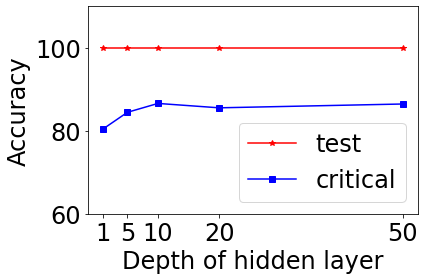

In [44]:
from matplotlib import pyplot as plt

## Print the result for different N
%matplotlib inline

plt.plot(N_array, test_array, 'r-*', label="test")
plt.plot(N_array, critical_array, 'b-s', label="critical")
plt.ylim(60,110)
plt.xlabel('Depth of hidden layer', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()


## From what I have learned in https://cs231n.github.io/convolutional-networks/. We can calculate the size the output data by following two equations:
$$W_{out} = \frac{W_{in}-F+2P}{S} + 1$$
$$H_{out} = \frac{H_{in}-F+2P}{S} + 1$$

Where<br>
W = input volume size <br>
F = Conv layer neurons, or a receptive field size or a filter size<br>
P = zero padding, which is a hyperparamter <br>
S = stride, which is a hyperparameter <br>

## I have also learn how to implement Conv2d through this website: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html. So rewrite the equations above, adopt the equation from Conv2d website we have got:
Input (N, $D_{in}$, $H_{in}$, $W_{in}$)<br>
output (N, $D_{out}$, $H_{out}$, $W_{out}$)<br>
$$H_{out} = \left[\frac{H_{in} +2\times padding[0]-dilation[0]\times(kernel size[0]-1)-1}{stride[0]}+1 \right]$$<br>
$$W_{out} = \left[\frac{W_{in} +2\times padding[1]-dilation[1]\times(kernel size[1]-1)-1}{stride[1]}+1 \right]$$<br>


## The convolutional layer we have can be summarized by the four numbers $[N,D_{in},H,W]=[N,1,41,41]$. I have set kernel size = 2, a receptive field size or a filter size = $2\times 2$, Stride = 2 and zero padding = 1. I then obtain  $[N,D_{in},H,W]=[N,1,20,20]$. Since, we are having 2 classes (corresponding to the ordered and disordered phases). In fact, results in layer of size $[N,D_{in},H,W]=[N,1,10,10]$. This layer is then hooked up to a linear layer that takes as an `[input,output]` of the form `[N*10*10*1,2]`. The accuracy of critical dataset does not changed much still in range of 80-90%, but no more than 90% this time. The accuracy drops a little bit. Furthermore, it runs much faster than previous code. Just out of curiousity and to check if my thoughts are correct, I have set Kernel size = 4 at following code, to see how it perform.

## In addition, the result of these equations has to be integer, otherwise indicating that the neurons don’t “fit” neatly and symmetrically across the input. Therefore, this setting of the hyperparameters is considered to be invalid, and a ConvNet library could throw an exception or zero pad the rest to make it fit, or crop the input to make it fit, or something



# Stride = 2, Kernel size =4, zero padding = 1 --> $H_{out}$= 10, $W_{out}$ = 10

Finished loading data
Training on 80 percent of examples
Finished loading data
Testing on 20 percent of examples
Finished loading data
Predicting on 30000 critical examples
The number of neurons in CNN layer is 1
Train Epoch: 1 [0/104000 (0%)]	Loss: 0.738271
Train Epoch: 1 [640/104000 (1%)]	Loss: 0.462683
Train Epoch: 1 [1280/104000 (1%)]	Loss: 0.283063
Train Epoch: 1 [1920/104000 (2%)]	Loss: 0.193163
Train Epoch: 1 [2560/104000 (2%)]	Loss: 0.156372
Train Epoch: 1 [3200/104000 (3%)]	Loss: 0.091870
Train Epoch: 1 [3840/104000 (4%)]	Loss: 0.095203
Train Epoch: 1 [4480/104000 (4%)]	Loss: 0.073745
Train Epoch: 1 [5120/104000 (5%)]	Loss: 0.064814
Train Epoch: 1 [5760/104000 (6%)]	Loss: 0.075143
Train Epoch: 1 [6400/104000 (6%)]	Loss: 0.048107
Train Epoch: 1 [7040/104000 (7%)]	Loss: 0.042865
Train Epoch: 1 [7680/104000 (7%)]	Loss: 0.042612
Train Epoch: 1 [8320/104000 (8%)]	Loss: 0.049624
Train Epoch: 1 [8960/104000 (9%)]	Loss: 0.034062
Train Epoch: 1 [9600/104000 (9%)]	Loss: 0.033131
Train E

Train Epoch: 1 [101120/104000 (97%)]	Loss: 0.003238
Train Epoch: 1 [101760/104000 (98%)]	Loss: 0.003276
Train Epoch: 1 [102400/104000 (98%)]	Loss: 0.001961
Train Epoch: 1 [103040/104000 (99%)]	Loss: 0.004408
Train Epoch: 1 [103680/104000 (100%)]	Loss: 0.002602

Test set: Average loss: 0.0022, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5681, Accuracy: 21827/30000 (73%)

Train Epoch: 2 [0/104000 (0%)]	Loss: 0.002143
Train Epoch: 2 [640/104000 (1%)]	Loss: 0.003457
Train Epoch: 2 [1280/104000 (1%)]	Loss: 0.002646
Train Epoch: 2 [1920/104000 (2%)]	Loss: 0.001826
Train Epoch: 2 [2560/104000 (2%)]	Loss: 0.008994
Train Epoch: 2 [3200/104000 (3%)]	Loss: 0.005981
Train Epoch: 2 [3840/104000 (4%)]	Loss: 0.004438
Train Epoch: 2 [4480/104000 (4%)]	Loss: 0.001350
Train Epoch: 2 [5120/104000 (5%)]	Loss: 0.002213
Train Epoch: 2 [5760/104000 (6%)]	Loss: 0.001874
Train Epoch: 2 [6400/104000 (6%)]	Loss: 0.003044
Train Epoch: 2 [7040/104000 (7%)]	Loss: 0.001647
Train Epoch: 2 [7680/10400

Train Epoch: 2 [99840/104000 (96%)]	Loss: 0.001651
Train Epoch: 2 [100480/104000 (97%)]	Loss: 0.000916
Train Epoch: 2 [101120/104000 (97%)]	Loss: 0.001606
Train Epoch: 2 [101760/104000 (98%)]	Loss: 0.003948
Train Epoch: 2 [102400/104000 (98%)]	Loss: 0.001051
Train Epoch: 2 [103040/104000 (99%)]	Loss: 0.002323
Train Epoch: 2 [103680/104000 (100%)]	Loss: 0.001239

Test set: Average loss: 0.0010, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5527, Accuracy: 22262/30000 (74%)

Train Epoch: 3 [0/104000 (0%)]	Loss: 0.001336
Train Epoch: 3 [640/104000 (1%)]	Loss: 0.001858
Train Epoch: 3 [1280/104000 (1%)]	Loss: 0.000933
Train Epoch: 3 [1920/104000 (2%)]	Loss: 0.000795
Train Epoch: 3 [2560/104000 (2%)]	Loss: 0.001359
Train Epoch: 3 [3200/104000 (3%)]	Loss: 0.000893
Train Epoch: 3 [3840/104000 (4%)]	Loss: 0.001014
Train Epoch: 3 [4480/104000 (4%)]	Loss: 0.001555
Train Epoch: 3 [5120/104000 (5%)]	Loss: 0.001094
Train Epoch: 3 [5760/104000 (6%)]	Loss: 0.001120
Train Epoch: 3 [6400/

Train Epoch: 3 [99200/104000 (95%)]	Loss: 0.000633
Train Epoch: 3 [99840/104000 (96%)]	Loss: 0.000745
Train Epoch: 3 [100480/104000 (97%)]	Loss: 0.000614
Train Epoch: 3 [101120/104000 (97%)]	Loss: 0.000620
Train Epoch: 3 [101760/104000 (98%)]	Loss: 0.000522
Train Epoch: 3 [102400/104000 (98%)]	Loss: 0.002364
Train Epoch: 3 [103040/104000 (99%)]	Loss: 0.001142
Train Epoch: 3 [103680/104000 (100%)]	Loss: 0.001121

Test set: Average loss: 0.0006, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5593, Accuracy: 22299/30000 (74%)

Train Epoch: 4 [0/104000 (0%)]	Loss: 0.000464
Train Epoch: 4 [640/104000 (1%)]	Loss: 0.003974
Train Epoch: 4 [1280/104000 (1%)]	Loss: 0.001843
Train Epoch: 4 [1920/104000 (2%)]	Loss: 0.000458
Train Epoch: 4 [2560/104000 (2%)]	Loss: 0.000666
Train Epoch: 4 [3200/104000 (3%)]	Loss: 0.003523
Train Epoch: 4 [3840/104000 (4%)]	Loss: 0.001219
Train Epoch: 4 [4480/104000 (4%)]	Loss: 0.000927
Train Epoch: 4 [5120/104000 (5%)]	Loss: 0.000514
Train Epoch: 4 [576

Train Epoch: 4 [98560/104000 (95%)]	Loss: 0.000448
Train Epoch: 4 [99200/104000 (95%)]	Loss: 0.000816
Train Epoch: 4 [99840/104000 (96%)]	Loss: 0.000662
Train Epoch: 4 [100480/104000 (97%)]	Loss: 0.000457
Train Epoch: 4 [101120/104000 (97%)]	Loss: 0.000472
Train Epoch: 4 [101760/104000 (98%)]	Loss: 0.000383
Train Epoch: 4 [102400/104000 (98%)]	Loss: 0.000342
Train Epoch: 4 [103040/104000 (99%)]	Loss: 0.000598
Train Epoch: 4 [103680/104000 (100%)]	Loss: 0.000663

Test set: Average loss: 0.0004, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.4466, Accuracy: 23568/30000 (79%)

Train Epoch: 5 [0/104000 (0%)]	Loss: 0.000308
Train Epoch: 5 [640/104000 (1%)]	Loss: 0.000404
Train Epoch: 5 [1280/104000 (1%)]	Loss: 0.000848
Train Epoch: 5 [1920/104000 (2%)]	Loss: 0.001129
Train Epoch: 5 [2560/104000 (2%)]	Loss: 0.000432
Train Epoch: 5 [3200/104000 (3%)]	Loss: 0.000306
Train Epoch: 5 [3840/104000 (4%)]	Loss: 0.000384
Train Epoch: 5 [4480/104000 (4%)]	Loss: 0.000405
Train Epoch: 5 [5

Train Epoch: 5 [97280/104000 (94%)]	Loss: 0.000500
Train Epoch: 5 [97920/104000 (94%)]	Loss: 0.000386
Train Epoch: 5 [98560/104000 (95%)]	Loss: 0.000239
Train Epoch: 5 [99200/104000 (95%)]	Loss: 0.000567
Train Epoch: 5 [99840/104000 (96%)]	Loss: 0.000519
Train Epoch: 5 [100480/104000 (97%)]	Loss: 0.000266
Train Epoch: 5 [101120/104000 (97%)]	Loss: 0.000581
Train Epoch: 5 [101760/104000 (98%)]	Loss: 0.000760
Train Epoch: 5 [102400/104000 (98%)]	Loss: 0.001147
Train Epoch: 5 [103040/104000 (99%)]	Loss: 0.000390
Train Epoch: 5 [103680/104000 (100%)]	Loss: 0.000259

Test set: Average loss: 0.0003, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5194, Accuracy: 22867/30000 (76%)

[100.0]
[76.22333333333333]
The number of neurons in CNN layer is 5
Train Epoch: 1 [0/104000 (0%)]	Loss: 0.821341
Train Epoch: 1 [640/104000 (1%)]	Loss: 0.338367
Train Epoch: 1 [1280/104000 (1%)]	Loss: 0.229954
Train Epoch: 1 [1920/104000 (2%)]	Loss: 0.119864
Train Epoch: 1 [2560/104000 (2%)]	Loss: 0.1

Train Epoch: 1 [96000/104000 (92%)]	Loss: 0.001665
Train Epoch: 1 [96640/104000 (93%)]	Loss: 0.000768
Train Epoch: 1 [97280/104000 (94%)]	Loss: 0.001793
Train Epoch: 1 [97920/104000 (94%)]	Loss: 0.001540
Train Epoch: 1 [98560/104000 (95%)]	Loss: 0.000888
Train Epoch: 1 [99200/104000 (95%)]	Loss: 0.000826
Train Epoch: 1 [99840/104000 (96%)]	Loss: 0.000631
Train Epoch: 1 [100480/104000 (97%)]	Loss: 0.000623
Train Epoch: 1 [101120/104000 (97%)]	Loss: 0.007925
Train Epoch: 1 [101760/104000 (98%)]	Loss: 0.001720
Train Epoch: 1 [102400/104000 (98%)]	Loss: 0.001252
Train Epoch: 1 [103040/104000 (99%)]	Loss: 0.001605
Train Epoch: 1 [103680/104000 (100%)]	Loss: 0.001279

Test set: Average loss: 0.0009, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5571, Accuracy: 22083/30000 (74%)

Train Epoch: 2 [0/104000 (0%)]	Loss: 0.000641
Train Epoch: 2 [640/104000 (1%)]	Loss: 0.001498
Train Epoch: 2 [1280/104000 (1%)]	Loss: 0.001393
Train Epoch: 2 [1920/104000 (2%)]	Loss: 0.000890
Train Epo

Train Epoch: 2 [93440/104000 (90%)]	Loss: 0.000501
Train Epoch: 2 [94080/104000 (90%)]	Loss: 0.000276
Train Epoch: 2 [94720/104000 (91%)]	Loss: 0.000440
Train Epoch: 2 [95360/104000 (92%)]	Loss: 0.000380
Train Epoch: 2 [96000/104000 (92%)]	Loss: 0.000401
Train Epoch: 2 [96640/104000 (93%)]	Loss: 0.000319
Train Epoch: 2 [97280/104000 (94%)]	Loss: 0.000604
Train Epoch: 2 [97920/104000 (94%)]	Loss: 0.000697
Train Epoch: 2 [98560/104000 (95%)]	Loss: 0.000933
Train Epoch: 2 [99200/104000 (95%)]	Loss: 0.000383
Train Epoch: 2 [99840/104000 (96%)]	Loss: 0.000415
Train Epoch: 2 [100480/104000 (97%)]	Loss: 0.000833
Train Epoch: 2 [101120/104000 (97%)]	Loss: 0.000290
Train Epoch: 2 [101760/104000 (98%)]	Loss: 0.001180
Train Epoch: 2 [102400/104000 (98%)]	Loss: 0.000262
Train Epoch: 2 [103040/104000 (99%)]	Loss: 0.000549
Train Epoch: 2 [103680/104000 (100%)]	Loss: 0.000251

Test set: Average loss: 0.0004, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5610, Accuracy: 22302/30000 (74%

Train Epoch: 3 [92160/104000 (89%)]	Loss: 0.000575
Train Epoch: 3 [92800/104000 (89%)]	Loss: 0.000329
Train Epoch: 3 [93440/104000 (90%)]	Loss: 0.000415
Train Epoch: 3 [94080/104000 (90%)]	Loss: 0.000233
Train Epoch: 3 [94720/104000 (91%)]	Loss: 0.000224
Train Epoch: 3 [95360/104000 (92%)]	Loss: 0.000302
Train Epoch: 3 [96000/104000 (92%)]	Loss: 0.000222
Train Epoch: 3 [96640/104000 (93%)]	Loss: 0.000175
Train Epoch: 3 [97280/104000 (94%)]	Loss: 0.000477
Train Epoch: 3 [97920/104000 (94%)]	Loss: 0.000299
Train Epoch: 3 [98560/104000 (95%)]	Loss: 0.000384
Train Epoch: 3 [99200/104000 (95%)]	Loss: 0.000384
Train Epoch: 3 [99840/104000 (96%)]	Loss: 0.000212
Train Epoch: 3 [100480/104000 (97%)]	Loss: 0.000261
Train Epoch: 3 [101120/104000 (97%)]	Loss: 0.000829
Train Epoch: 3 [101760/104000 (98%)]	Loss: 0.000316
Train Epoch: 3 [102400/104000 (98%)]	Loss: 0.000211
Train Epoch: 3 [103040/104000 (99%)]	Loss: 0.000216
Train Epoch: 3 [103680/104000 (100%)]	Loss: 0.000290

Test set: Average loss:

Train Epoch: 4 [90880/104000 (87%)]	Loss: 0.000489
Train Epoch: 4 [91520/104000 (88%)]	Loss: 0.000108
Train Epoch: 4 [92160/104000 (89%)]	Loss: 0.000132
Train Epoch: 4 [92800/104000 (89%)]	Loss: 0.000241
Train Epoch: 4 [93440/104000 (90%)]	Loss: 0.000186
Train Epoch: 4 [94080/104000 (90%)]	Loss: 0.000148
Train Epoch: 4 [94720/104000 (91%)]	Loss: 0.000283
Train Epoch: 4 [95360/104000 (92%)]	Loss: 0.000106
Train Epoch: 4 [96000/104000 (92%)]	Loss: 0.000113
Train Epoch: 4 [96640/104000 (93%)]	Loss: 0.000172
Train Epoch: 4 [97280/104000 (94%)]	Loss: 0.000147
Train Epoch: 4 [97920/104000 (94%)]	Loss: 0.000472
Train Epoch: 4 [98560/104000 (95%)]	Loss: 0.000274
Train Epoch: 4 [99200/104000 (95%)]	Loss: 0.000130
Train Epoch: 4 [99840/104000 (96%)]	Loss: 0.000429
Train Epoch: 4 [100480/104000 (97%)]	Loss: 0.000126
Train Epoch: 4 [101120/104000 (97%)]	Loss: 0.000362
Train Epoch: 4 [101760/104000 (98%)]	Loss: 0.000159
Train Epoch: 4 [102400/104000 (98%)]	Loss: 0.000162
Train Epoch: 4 [103040/1040

Train Epoch: 5 [88320/104000 (85%)]	Loss: 0.000157
Train Epoch: 5 [88960/104000 (86%)]	Loss: 0.000237
Train Epoch: 5 [89600/104000 (86%)]	Loss: 0.000149
Train Epoch: 5 [90240/104000 (87%)]	Loss: 0.000110
Train Epoch: 5 [90880/104000 (87%)]	Loss: 0.000300
Train Epoch: 5 [91520/104000 (88%)]	Loss: 0.000117
Train Epoch: 5 [92160/104000 (89%)]	Loss: 0.000284
Train Epoch: 5 [92800/104000 (89%)]	Loss: 0.000129
Train Epoch: 5 [93440/104000 (90%)]	Loss: 0.000242
Train Epoch: 5 [94080/104000 (90%)]	Loss: 0.000149
Train Epoch: 5 [94720/104000 (91%)]	Loss: 0.000174
Train Epoch: 5 [95360/104000 (92%)]	Loss: 0.000460
Train Epoch: 5 [96000/104000 (92%)]	Loss: 0.000459
Train Epoch: 5 [96640/104000 (93%)]	Loss: 0.000662
Train Epoch: 5 [97280/104000 (94%)]	Loss: 0.000099
Train Epoch: 5 [97920/104000 (94%)]	Loss: 0.000368
Train Epoch: 5 [98560/104000 (95%)]	Loss: 0.000269
Train Epoch: 5 [99200/104000 (95%)]	Loss: 0.000267
Train Epoch: 5 [99840/104000 (96%)]	Loss: 0.000184
Train Epoch: 5 [100480/104000 (

Train Epoch: 1 [85120/104000 (82%)]	Loss: 0.000537
Train Epoch: 1 [85760/104000 (82%)]	Loss: 0.000621
Train Epoch: 1 [86400/104000 (83%)]	Loss: 0.000831
Train Epoch: 1 [87040/104000 (84%)]	Loss: 0.000783
Train Epoch: 1 [87680/104000 (84%)]	Loss: 0.001407
Train Epoch: 1 [88320/104000 (85%)]	Loss: 0.000601
Train Epoch: 1 [88960/104000 (86%)]	Loss: 0.001158
Train Epoch: 1 [89600/104000 (86%)]	Loss: 0.000637
Train Epoch: 1 [90240/104000 (87%)]	Loss: 0.001278
Train Epoch: 1 [90880/104000 (87%)]	Loss: 0.000553
Train Epoch: 1 [91520/104000 (88%)]	Loss: 0.001996
Train Epoch: 1 [92160/104000 (89%)]	Loss: 0.000467
Train Epoch: 1 [92800/104000 (89%)]	Loss: 0.000470
Train Epoch: 1 [93440/104000 (90%)]	Loss: 0.000453
Train Epoch: 1 [94080/104000 (90%)]	Loss: 0.000612
Train Epoch: 1 [94720/104000 (91%)]	Loss: 0.000374
Train Epoch: 1 [95360/104000 (92%)]	Loss: 0.001354
Train Epoch: 1 [96000/104000 (92%)]	Loss: 0.000593
Train Epoch: 1 [96640/104000 (93%)]	Loss: 0.000681
Train Epoch: 1 [97280/104000 (9

Train Epoch: 2 [83840/104000 (81%)]	Loss: 0.000218
Train Epoch: 2 [84480/104000 (81%)]	Loss: 0.000218
Train Epoch: 2 [85120/104000 (82%)]	Loss: 0.000218
Train Epoch: 2 [85760/104000 (82%)]	Loss: 0.000262
Train Epoch: 2 [86400/104000 (83%)]	Loss: 0.000287
Train Epoch: 2 [87040/104000 (84%)]	Loss: 0.000244
Train Epoch: 2 [87680/104000 (84%)]	Loss: 0.000710
Train Epoch: 2 [88320/104000 (85%)]	Loss: 0.000278
Train Epoch: 2 [88960/104000 (86%)]	Loss: 0.000469
Train Epoch: 2 [89600/104000 (86%)]	Loss: 0.000341
Train Epoch: 2 [90240/104000 (87%)]	Loss: 0.000178
Train Epoch: 2 [90880/104000 (87%)]	Loss: 0.000202
Train Epoch: 2 [91520/104000 (88%)]	Loss: 0.000134
Train Epoch: 2 [92160/104000 (89%)]	Loss: 0.000706
Train Epoch: 2 [92800/104000 (89%)]	Loss: 0.000599
Train Epoch: 2 [93440/104000 (90%)]	Loss: 0.000321
Train Epoch: 2 [94080/104000 (90%)]	Loss: 0.000784
Train Epoch: 2 [94720/104000 (91%)]	Loss: 0.000283
Train Epoch: 2 [95360/104000 (92%)]	Loss: 0.000314
Train Epoch: 2 [96000/104000 (9

Train Epoch: 3 [81920/104000 (79%)]	Loss: 0.001083
Train Epoch: 3 [82560/104000 (79%)]	Loss: 0.000133
Train Epoch: 3 [83200/104000 (80%)]	Loss: 0.000134
Train Epoch: 3 [83840/104000 (81%)]	Loss: 0.000115
Train Epoch: 3 [84480/104000 (81%)]	Loss: 0.000106
Train Epoch: 3 [85120/104000 (82%)]	Loss: 0.000280
Train Epoch: 3 [85760/104000 (82%)]	Loss: 0.000125
Train Epoch: 3 [86400/104000 (83%)]	Loss: 0.000156
Train Epoch: 3 [87040/104000 (84%)]	Loss: 0.000164
Train Epoch: 3 [87680/104000 (84%)]	Loss: 0.000251
Train Epoch: 3 [88320/104000 (85%)]	Loss: 0.000151
Train Epoch: 3 [88960/104000 (86%)]	Loss: 0.000143
Train Epoch: 3 [89600/104000 (86%)]	Loss: 0.000199
Train Epoch: 3 [90240/104000 (87%)]	Loss: 0.000599
Train Epoch: 3 [90880/104000 (87%)]	Loss: 0.000489
Train Epoch: 3 [91520/104000 (88%)]	Loss: 0.000172
Train Epoch: 3 [92160/104000 (89%)]	Loss: 0.000164
Train Epoch: 3 [92800/104000 (89%)]	Loss: 0.000140
Train Epoch: 3 [93440/104000 (90%)]	Loss: 0.000225
Train Epoch: 3 [94080/104000 (9

Train Epoch: 4 [79360/104000 (76%)]	Loss: 0.000196
Train Epoch: 4 [80000/104000 (77%)]	Loss: 0.000116
Train Epoch: 4 [80640/104000 (78%)]	Loss: 0.000125
Train Epoch: 4 [81280/104000 (78%)]	Loss: 0.000084
Train Epoch: 4 [81920/104000 (79%)]	Loss: 0.000604
Train Epoch: 4 [82560/104000 (79%)]	Loss: 0.000170
Train Epoch: 4 [83200/104000 (80%)]	Loss: 0.000217
Train Epoch: 4 [83840/104000 (81%)]	Loss: 0.000482
Train Epoch: 4 [84480/104000 (81%)]	Loss: 0.000085
Train Epoch: 4 [85120/104000 (82%)]	Loss: 0.000280
Train Epoch: 4 [85760/104000 (82%)]	Loss: 0.000148
Train Epoch: 4 [86400/104000 (83%)]	Loss: 0.000184
Train Epoch: 4 [87040/104000 (84%)]	Loss: 0.000077
Train Epoch: 4 [87680/104000 (84%)]	Loss: 0.000381
Train Epoch: 4 [88320/104000 (85%)]	Loss: 0.000096
Train Epoch: 4 [88960/104000 (86%)]	Loss: 0.000075
Train Epoch: 4 [89600/104000 (86%)]	Loss: 0.000304
Train Epoch: 4 [90240/104000 (87%)]	Loss: 0.000496
Train Epoch: 4 [90880/104000 (87%)]	Loss: 0.000090
Train Epoch: 4 [91520/104000 (8

Train Epoch: 5 [76800/104000 (74%)]	Loss: 0.000076
Train Epoch: 5 [77440/104000 (74%)]	Loss: 0.000075
Train Epoch: 5 [78080/104000 (75%)]	Loss: 0.000488
Train Epoch: 5 [78720/104000 (76%)]	Loss: 0.000095
Train Epoch: 5 [79360/104000 (76%)]	Loss: 0.000045
Train Epoch: 5 [80000/104000 (77%)]	Loss: 0.000112
Train Epoch: 5 [80640/104000 (78%)]	Loss: 0.000078
Train Epoch: 5 [81280/104000 (78%)]	Loss: 0.000073
Train Epoch: 5 [81920/104000 (79%)]	Loss: 0.000074
Train Epoch: 5 [82560/104000 (79%)]	Loss: 0.000236
Train Epoch: 5 [83200/104000 (80%)]	Loss: 0.000168
Train Epoch: 5 [83840/104000 (81%)]	Loss: 0.000108
Train Epoch: 5 [84480/104000 (81%)]	Loss: 0.000132
Train Epoch: 5 [85120/104000 (82%)]	Loss: 0.000057
Train Epoch: 5 [85760/104000 (82%)]	Loss: 0.000119
Train Epoch: 5 [86400/104000 (83%)]	Loss: 0.000088
Train Epoch: 5 [87040/104000 (84%)]	Loss: 0.000063
Train Epoch: 5 [87680/104000 (84%)]	Loss: 0.000114
Train Epoch: 5 [88320/104000 (85%)]	Loss: 0.000297
Train Epoch: 5 [88960/104000 (8

Train Epoch: 1 [72960/104000 (70%)]	Loss: 0.000431
Train Epoch: 1 [73600/104000 (71%)]	Loss: 0.000506
Train Epoch: 1 [74240/104000 (71%)]	Loss: 0.000451
Train Epoch: 1 [74880/104000 (72%)]	Loss: 0.000379
Train Epoch: 1 [75520/104000 (73%)]	Loss: 0.000368
Train Epoch: 1 [76160/104000 (73%)]	Loss: 0.000495
Train Epoch: 1 [76800/104000 (74%)]	Loss: 0.002230
Train Epoch: 1 [77440/104000 (74%)]	Loss: 0.000432
Train Epoch: 1 [78080/104000 (75%)]	Loss: 0.000371
Train Epoch: 1 [78720/104000 (76%)]	Loss: 0.000358
Train Epoch: 1 [79360/104000 (76%)]	Loss: 0.000414
Train Epoch: 1 [80000/104000 (77%)]	Loss: 0.000515
Train Epoch: 1 [80640/104000 (78%)]	Loss: 0.000420
Train Epoch: 1 [81280/104000 (78%)]	Loss: 0.000339
Train Epoch: 1 [81920/104000 (79%)]	Loss: 0.001930
Train Epoch: 1 [82560/104000 (79%)]	Loss: 0.000427
Train Epoch: 1 [83200/104000 (80%)]	Loss: 0.000444
Train Epoch: 1 [83840/104000 (81%)]	Loss: 0.000519
Train Epoch: 1 [84480/104000 (81%)]	Loss: 0.000303
Train Epoch: 1 [85120/104000 (8

Train Epoch: 2 [70400/104000 (68%)]	Loss: 0.000152
Train Epoch: 2 [71040/104000 (68%)]	Loss: 0.000171
Train Epoch: 2 [71680/104000 (69%)]	Loss: 0.000324
Train Epoch: 2 [72320/104000 (70%)]	Loss: 0.000107
Train Epoch: 2 [72960/104000 (70%)]	Loss: 0.000362
Train Epoch: 2 [73600/104000 (71%)]	Loss: 0.000426
Train Epoch: 2 [74240/104000 (71%)]	Loss: 0.000328
Train Epoch: 2 [74880/104000 (72%)]	Loss: 0.000268
Train Epoch: 2 [75520/104000 (73%)]	Loss: 0.000274
Train Epoch: 2 [76160/104000 (73%)]	Loss: 0.000163
Train Epoch: 2 [76800/104000 (74%)]	Loss: 0.000745
Train Epoch: 2 [77440/104000 (74%)]	Loss: 0.000156
Train Epoch: 2 [78080/104000 (75%)]	Loss: 0.000331
Train Epoch: 2 [78720/104000 (76%)]	Loss: 0.000116
Train Epoch: 2 [79360/104000 (76%)]	Loss: 0.000843
Train Epoch: 2 [80000/104000 (77%)]	Loss: 0.000170
Train Epoch: 2 [80640/104000 (78%)]	Loss: 0.000419
Train Epoch: 2 [81280/104000 (78%)]	Loss: 0.000110
Train Epoch: 2 [81920/104000 (79%)]	Loss: 0.000110
Train Epoch: 2 [82560/104000 (7

Train Epoch: 3 [67840/104000 (65%)]	Loss: 0.000173
Train Epoch: 3 [68480/104000 (66%)]	Loss: 0.000151
Train Epoch: 3 [69120/104000 (66%)]	Loss: 0.000073
Train Epoch: 3 [69760/104000 (67%)]	Loss: 0.000151
Train Epoch: 3 [70400/104000 (68%)]	Loss: 0.000149
Train Epoch: 3 [71040/104000 (68%)]	Loss: 0.000134
Train Epoch: 3 [71680/104000 (69%)]	Loss: 0.000160
Train Epoch: 3 [72320/104000 (70%)]	Loss: 0.000220
Train Epoch: 3 [72960/104000 (70%)]	Loss: 0.000116
Train Epoch: 3 [73600/104000 (71%)]	Loss: 0.000074
Train Epoch: 3 [74240/104000 (71%)]	Loss: 0.000370
Train Epoch: 3 [74880/104000 (72%)]	Loss: 0.000129
Train Epoch: 3 [75520/104000 (73%)]	Loss: 0.000096
Train Epoch: 3 [76160/104000 (73%)]	Loss: 0.000130
Train Epoch: 3 [76800/104000 (74%)]	Loss: 0.000087
Train Epoch: 3 [77440/104000 (74%)]	Loss: 0.000116
Train Epoch: 3 [78080/104000 (75%)]	Loss: 0.000291
Train Epoch: 3 [78720/104000 (76%)]	Loss: 0.000085
Train Epoch: 3 [79360/104000 (76%)]	Loss: 0.000081
Train Epoch: 3 [80000/104000 (7

Train Epoch: 4 [65920/104000 (63%)]	Loss: 0.000246
Train Epoch: 4 [66560/104000 (64%)]	Loss: 0.000053
Train Epoch: 4 [67200/104000 (65%)]	Loss: 0.000104
Train Epoch: 4 [67840/104000 (65%)]	Loss: 0.000384
Train Epoch: 4 [68480/104000 (66%)]	Loss: 0.000059
Train Epoch: 4 [69120/104000 (66%)]	Loss: 0.000068
Train Epoch: 4 [69760/104000 (67%)]	Loss: 0.000083
Train Epoch: 4 [70400/104000 (68%)]	Loss: 0.000276
Train Epoch: 4 [71040/104000 (68%)]	Loss: 0.000230
Train Epoch: 4 [71680/104000 (69%)]	Loss: 0.000072
Train Epoch: 4 [72320/104000 (70%)]	Loss: 0.000181
Train Epoch: 4 [72960/104000 (70%)]	Loss: 0.000156
Train Epoch: 4 [73600/104000 (71%)]	Loss: 0.000201
Train Epoch: 4 [74240/104000 (71%)]	Loss: 0.000061
Train Epoch: 4 [74880/104000 (72%)]	Loss: 0.000131
Train Epoch: 4 [75520/104000 (73%)]	Loss: 0.000071
Train Epoch: 4 [76160/104000 (73%)]	Loss: 0.000033
Train Epoch: 4 [76800/104000 (74%)]	Loss: 0.000121
Train Epoch: 4 [77440/104000 (74%)]	Loss: 0.000060
Train Epoch: 4 [78080/104000 (7

Train Epoch: 5 [64000/104000 (62%)]	Loss: 0.000573
Train Epoch: 5 [64640/104000 (62%)]	Loss: 0.000034
Train Epoch: 5 [65280/104000 (63%)]	Loss: 0.000125
Train Epoch: 5 [65920/104000 (63%)]	Loss: 0.000090
Train Epoch: 5 [66560/104000 (64%)]	Loss: 0.000111
Train Epoch: 5 [67200/104000 (65%)]	Loss: 0.000046
Train Epoch: 5 [67840/104000 (65%)]	Loss: 0.000048
Train Epoch: 5 [68480/104000 (66%)]	Loss: 0.000053
Train Epoch: 5 [69120/104000 (66%)]	Loss: 0.000059
Train Epoch: 5 [69760/104000 (67%)]	Loss: 0.000073
Train Epoch: 5 [70400/104000 (68%)]	Loss: 0.000028
Train Epoch: 5 [71040/104000 (68%)]	Loss: 0.000065
Train Epoch: 5 [71680/104000 (69%)]	Loss: 0.000031
Train Epoch: 5 [72320/104000 (70%)]	Loss: 0.000070
Train Epoch: 5 [72960/104000 (70%)]	Loss: 0.000174
Train Epoch: 5 [73600/104000 (71%)]	Loss: 0.000309
Train Epoch: 5 [74240/104000 (71%)]	Loss: 0.000204
Train Epoch: 5 [74880/104000 (72%)]	Loss: 0.000089
Train Epoch: 5 [75520/104000 (73%)]	Loss: 0.000041
Train Epoch: 5 [76160/104000 (7

Train Epoch: 1 [60160/104000 (58%)]	Loss: 0.000168
Train Epoch: 1 [60800/104000 (58%)]	Loss: 0.000350
Train Epoch: 1 [61440/104000 (59%)]	Loss: 0.000329
Train Epoch: 1 [62080/104000 (60%)]	Loss: 0.000237
Train Epoch: 1 [62720/104000 (60%)]	Loss: 0.000420
Train Epoch: 1 [63360/104000 (61%)]	Loss: 0.000221
Train Epoch: 1 [64000/104000 (62%)]	Loss: 0.002318
Train Epoch: 1 [64640/104000 (62%)]	Loss: 0.000273
Train Epoch: 1 [65280/104000 (63%)]	Loss: 0.000373
Train Epoch: 1 [65920/104000 (63%)]	Loss: 0.000607
Train Epoch: 1 [66560/104000 (64%)]	Loss: 0.001193
Train Epoch: 1 [67200/104000 (65%)]	Loss: 0.000440
Train Epoch: 1 [67840/104000 (65%)]	Loss: 0.000124
Train Epoch: 1 [68480/104000 (66%)]	Loss: 0.000373
Train Epoch: 1 [69120/104000 (66%)]	Loss: 0.000620
Train Epoch: 1 [69760/104000 (67%)]	Loss: 0.000180
Train Epoch: 1 [70400/104000 (68%)]	Loss: 0.000304
Train Epoch: 1 [71040/104000 (68%)]	Loss: 0.000152
Train Epoch: 1 [71680/104000 (69%)]	Loss: 0.000139
Train Epoch: 1 [72320/104000 (7

Train Epoch: 2 [57600/104000 (55%)]	Loss: 0.000783
Train Epoch: 2 [58240/104000 (56%)]	Loss: 0.000233
Train Epoch: 2 [58880/104000 (57%)]	Loss: 0.000065
Train Epoch: 2 [59520/104000 (57%)]	Loss: 0.000659
Train Epoch: 2 [60160/104000 (58%)]	Loss: 0.000065
Train Epoch: 2 [60800/104000 (58%)]	Loss: 0.000245
Train Epoch: 2 [61440/104000 (59%)]	Loss: 0.000066
Train Epoch: 2 [62080/104000 (60%)]	Loss: 0.000336
Train Epoch: 2 [62720/104000 (60%)]	Loss: 0.000116
Train Epoch: 2 [63360/104000 (61%)]	Loss: 0.000800
Train Epoch: 2 [64000/104000 (62%)]	Loss: 0.000391
Train Epoch: 2 [64640/104000 (62%)]	Loss: 0.000414
Train Epoch: 2 [65280/104000 (63%)]	Loss: 0.000062
Train Epoch: 2 [65920/104000 (63%)]	Loss: 0.000060
Train Epoch: 2 [66560/104000 (64%)]	Loss: 0.000062
Train Epoch: 2 [67200/104000 (65%)]	Loss: 0.000091
Train Epoch: 2 [67840/104000 (65%)]	Loss: 0.000073
Train Epoch: 2 [68480/104000 (66%)]	Loss: 0.000084
Train Epoch: 2 [69120/104000 (66%)]	Loss: 0.000084
Train Epoch: 2 [69760/104000 (6

Train Epoch: 3 [55040/104000 (53%)]	Loss: 0.000051
Train Epoch: 3 [55680/104000 (54%)]	Loss: 0.000084
Train Epoch: 3 [56320/104000 (54%)]	Loss: 0.000034
Train Epoch: 3 [56960/104000 (55%)]	Loss: 0.000074
Train Epoch: 3 [57600/104000 (55%)]	Loss: 0.000219
Train Epoch: 3 [58240/104000 (56%)]	Loss: 0.000040
Train Epoch: 3 [58880/104000 (57%)]	Loss: 0.000218
Train Epoch: 3 [59520/104000 (57%)]	Loss: 0.000045
Train Epoch: 3 [60160/104000 (58%)]	Loss: 0.000028
Train Epoch: 3 [60800/104000 (58%)]	Loss: 0.000031
Train Epoch: 3 [61440/104000 (59%)]	Loss: 0.000068
Train Epoch: 3 [62080/104000 (60%)]	Loss: 0.000333
Train Epoch: 3 [62720/104000 (60%)]	Loss: 0.000088
Train Epoch: 3 [63360/104000 (61%)]	Loss: 0.000038
Train Epoch: 3 [64000/104000 (62%)]	Loss: 0.000050
Train Epoch: 3 [64640/104000 (62%)]	Loss: 0.000060
Train Epoch: 3 [65280/104000 (63%)]	Loss: 0.000057
Train Epoch: 3 [65920/104000 (63%)]	Loss: 0.000124
Train Epoch: 3 [66560/104000 (64%)]	Loss: 0.000663
Train Epoch: 3 [67200/104000 (6

Train Epoch: 4 [52480/104000 (50%)]	Loss: 0.000173
Train Epoch: 4 [53120/104000 (51%)]	Loss: 0.000019
Train Epoch: 4 [53760/104000 (52%)]	Loss: 0.000428
Train Epoch: 4 [54400/104000 (52%)]	Loss: 0.000135
Train Epoch: 4 [55040/104000 (53%)]	Loss: 0.000046
Train Epoch: 4 [55680/104000 (54%)]	Loss: 0.000047
Train Epoch: 4 [56320/104000 (54%)]	Loss: 0.000987
Train Epoch: 4 [56960/104000 (55%)]	Loss: 0.000019
Train Epoch: 4 [57600/104000 (55%)]	Loss: 0.000125
Train Epoch: 4 [58240/104000 (56%)]	Loss: 0.000018
Train Epoch: 4 [58880/104000 (57%)]	Loss: 0.000046
Train Epoch: 4 [59520/104000 (57%)]	Loss: 0.000035
Train Epoch: 4 [60160/104000 (58%)]	Loss: 0.000044
Train Epoch: 4 [60800/104000 (58%)]	Loss: 0.000035
Train Epoch: 4 [61440/104000 (59%)]	Loss: 0.000021
Train Epoch: 4 [62080/104000 (60%)]	Loss: 0.000115
Train Epoch: 4 [62720/104000 (60%)]	Loss: 0.000034
Train Epoch: 4 [63360/104000 (61%)]	Loss: 0.000030
Train Epoch: 4 [64000/104000 (62%)]	Loss: 0.000073
Train Epoch: 4 [64640/104000 (6

Train Epoch: 5 [49920/104000 (48%)]	Loss: 0.000034
Train Epoch: 5 [50560/104000 (49%)]	Loss: 0.000079
Train Epoch: 5 [51200/104000 (49%)]	Loss: 0.000020
Train Epoch: 5 [51840/104000 (50%)]	Loss: 0.000148
Train Epoch: 5 [52480/104000 (50%)]	Loss: 0.000054
Train Epoch: 5 [53120/104000 (51%)]	Loss: 0.000087
Train Epoch: 5 [53760/104000 (52%)]	Loss: 0.000016
Train Epoch: 5 [54400/104000 (52%)]	Loss: 0.000062
Train Epoch: 5 [55040/104000 (53%)]	Loss: 0.000029
Train Epoch: 5 [55680/104000 (54%)]	Loss: 0.000032
Train Epoch: 5 [56320/104000 (54%)]	Loss: 0.000011
Train Epoch: 5 [56960/104000 (55%)]	Loss: 0.000013
Train Epoch: 5 [57600/104000 (55%)]	Loss: 0.000075
Train Epoch: 5 [58240/104000 (56%)]	Loss: 0.000022
Train Epoch: 5 [58880/104000 (57%)]	Loss: 0.000023
Train Epoch: 5 [59520/104000 (57%)]	Loss: 0.000030
Train Epoch: 5 [60160/104000 (58%)]	Loss: 0.000031
Train Epoch: 5 [60800/104000 (58%)]	Loss: 0.000145
Train Epoch: 5 [61440/104000 (59%)]	Loss: 0.000094
Train Epoch: 5 [62080/104000 (6

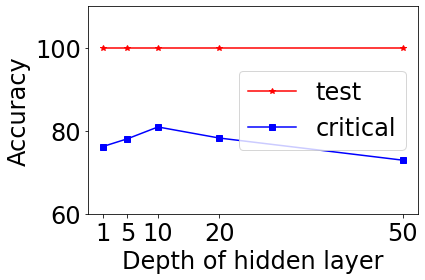

In [45]:
import torch.nn as nn # construct NN

class model(nn.Module):
    # create convolutional net
    def __init__(self, N=10, L=40):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()	
        # create convolutional layer with input depth 1 and output depth N
        self.conv1 = nn.Conv2d(1, N, kernel_size=4,stride=2, padding=1)
        # batch norm layer takes Depth
        self.bn1=nn.BatchNorm2d(N) 
        # create fully connected layer after maxpool operation reduced 40->18
        self.fc1 = nn.Linear(10*10*N, 2) 	
        self.N=N
        self.L=L
        print("The number of neurons in CNN layer is %i"%(N))

    def forward(self, x):
        #Unsqueeze command indicates one channel and turns x.shape from (:,40,40) to (:,1, 40,40)
        x=F.relu(self.conv1(torch.unsqueeze(x,1).float()))
        #print(x.shape)  often useful to look at shapes for debugging
        x = F.max_pool2d(x,2)	 
        #print(x.shape)
        x=self.bn1(x) # largely unnecessary and here just for pedagogical purposes
        return F.log_softmax(self.fc1(x.view(-1,10*10*self.N)), dim=1)

import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# training settings
parser = argparse.ArgumentParser(description='PyTorch Convmodel Ising Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.epochs=5
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

cuda_kwargs = {'num_workers': 0, 'pin_memory': True} if args.cuda else {}

import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

# load data
train_loader, test_loader, critical_loader=load_data(cuda_kwargs)

test_array=[]
critical_array=[]

# create array of depth of convolutional layer
N_array=[1,5,10,20,50]

# loop over depths
for N in N_array:
    CNN = model(N=N)
    if args.cuda:
        CNN.cuda()

    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(CNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(CNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    # train the CNN and test its performance at each epoch
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        if epoch==args.epochs:
            test_array.append(test(test_loader,verbose='Test'))
            critical_array.append(test(critical_loader,verbose='Critical'))
        else:
            test(test_loader,verbose='Test')
            test(critical_loader,verbose='Critical')
    print(test_array)
    print(critical_array)
    
from matplotlib import pyplot as plt

## Print the result for different N
%matplotlib inline

plt.plot(N_array, test_array, 'r-*', label="test")
plt.plot(N_array, critical_array, 'b-s', label="critical")
plt.ylim(60,110)
plt.xlabel('Depth of hidden layer', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()


## Obviously, the accuracy of critical region drops around 4% overall, which makes sense. Smaller steps lead more accurated result.

In [ ]:
ADR: 2/2